In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3,1,0"  # GPU ID

In [2]:
from exp.nb_databunch import *
from exp.fastai_imports import *
from exp.nb_AmishDataLoaders import *
from exp.amish_sites import *
from exp.resultsNplots import *
from exp.nb_spatiailMaxPooling import SpatialMaxPooling
from exp.nb_predict import *


from datetime import datetime


In [3]:
from exp.nb_predict import covModel,getArch,getNparams

In [4]:
import seaborn as sns

sns.set_style('darkgrid',{'axes.spines.bottom': True,
             'axes.spines.left': True,
             'axes.spines.right': True,
             'axes.spines.top': True,
             'axes.edgecolor':'.0'})

sns.set_context('talk')
sns.set_palette('colorblind')

# Inputs (cdv, data_path, pathology) 

In [5]:
amish_csv = 'data/AMISH_SO_QC.csv' # 'AMISH_12192019_wHypoDrusen.csv' ; #'AMISH_SO_QC.csv'
amish_df = pd.read_csv(amish_csv)


In [6]:
amish_csv2 = 'data/AMISH_12192019_wHypoDrusen.csv' 
amish_df2 = pd.read_csv(amish_csv2)

In [7]:
new_pathologies = ['CENTER','GROUP','INDIVIDUAL','EXAM_DATE','CO_RPE_V3MM_L0.03_OD','CO_RPE_V3MM_L0.03_OS','CO_Drusen_Core_OD','CO_Drusen_Core_OS','IRP_RP_OD','IRP_RP_OS']
amish_df = pd.merge(amish_df,amish_df2[new_pathologies],how='inner',on=['CENTER','GROUP','INDIVIDUAL','EXAM_DATE'])

In [8]:
amish_df['CASE_ID_SHORT'] = amish_df.CASE_ID.apply(lambda x: '_'.join(x.split('_')[:2]))
amish_df = validateNumerical(amish_df)
amish_df = binarizeDataFrame(amish_df,cat_cols)

data_type='biomarkers'
df = amish_df


demog_df = pd.read_csv('data/demog.txt')
demog_df['CASE_ID'] = demog_df.ID.apply(lambda x: '_'.join([f'{int(i):04d}' for i in re.findall('\d+',x)]))
demog_df = demog_df.set_index('CASE_ID')
demog_df = demog_df.drop_duplicates()


df = pd.merge(left=amish_df,right=demog_df,how='left',left_on='CASE_ID_SHORT',right_on='CASE_ID').set_index('CASE_ID')
df = df.drop_duplicates(subset=['GROUP','INDIVIDUAL'])

age_m = df.Age[df.CENTER.isin(['UPEN','VAN'])].mean()
age_s = df.Age[df.CENTER.isin(['UPEN','VAN'])].std()

df['Gender_OD'] = df.Gender
df['Gender_OS'] = df.Gender
df['Age_OD'] = (df.Age - age_m)/age_s
df['Age_OS'] = (df.Age - age_m)/age_s
df = binarizeDataFrame(df,['Gender_OS','Gender_OD'])

In [9]:
fullDisplay(df.head(7))

,STUDY,SUBSTUDY,CENTER,GROUP,INDIVIDUAL,EXAM_DATE,EXAMINER,EYE,CO_COMMENTS_OD,CO_COMMENTS_OS,CO_ACTION_OD,CO_ACTION_OS,CO_OPTH_FINDINGS_OD,CO_OPTH_FINDINGS_OS,CO_QIMG_OD,CO_QIMG_OS,CO_RPE_A3MM_OD,CO_RPE_A3MM_OS,CO_RPE_A5MM_OD,CO_RPE_A5MM_OS,CO_RPE_V3MM_OD,CO_RPE_V3MM_OS,CO_RPE_V5MM_OD,CO_RPE_V5MM_OS,CO_GA_A5MM_OD,CO_GA_A5MM_OS,CO_SUBFOVEAL_OD,CO_SUBFOVEAL_OS,CO_SUBRETINAL_OD,CO_SUBRETINAL_OS,CO_SRTSRHRM_OD,CO_SRTSRHRM_OS,CO_INTRA_RCS_OD,CO_INTRA_RCS_OS,CO_OUTER_RT_OD,CO_OUTER_RT_OS,CO_SR_DRUSEN_OD,CO_SR_DRUSEN_OS,CO_HRF_IRHRFOND_OD,CO_HRF_IRHRFOND_OS,CO_HRF_HRFOD_OD,CO_HRF_HRFOD_OS,CO_HRF_LHRFOD_OD,CO_HRF_LHRFOD_OS,CO_PED_DPED_OD,CO_PED_DPED_OS,CO_PED_HPED_OD,CO_PED_HPED_OS,CO_PED_SEROUS_OD,CO_PED_SEROUS_OS,SO_COMMENTS_OD,SO_COMMENTS_OS,SO_ACTION_OD,SO_ACTION_OS,SO_OPTH_FINDINGS_OD,SO_OPTH_FINDINGS_OS,SO_QIMG_OD,SO_QIMG_OS,SO_RPE_A3MM_OD,SO_RPE_A3MM_OS,SO_RPE_A5MM_OD,SO_RPE_A5MM_OS,SO_RPE_V3MM_OD,SO_RPE_V3MM_OS,SO_RPE_V5MM_OD,SO_RPE_V5MM_OS,SO_GA_A5MM_OD,SO_GA_A5MM_OS,SO_SUBFOVEAL_OD,SO_SUBFOVEAL_OS,SO_SUBRETINAL_OD,SO_SUBRETINAL_OS,SO_SRTSRHRM_OD,SO_SRTSRHRM_OS,SO_INTRA_RCS_OD,SO_INTRA_RCS_OS,SO_OUTER_RT_OD,SO_OUTER_RT_OS,SO_SR_DRUSEN_OD,SO_SR_DRUSEN_OS,SO_HRF_IRHRFOND_OD,SO_HRF_IRHRFOND_OS,SO_HRF_HRFOD_OD,SO_HRF_HRFOD_OS,SO_HRF_LHRFOD_OD,SO_HRF_LHRFOD_OS,SO_PED_DPED_OD,SO_PED_DPED_OS,SO_PED_HPED_OD,SO_PED_HPED_OS,SO_PED_SEROUS_OD,SO_PED_SEROUS_OS,PAT_ID,CO_RPE_V3MM_YN_OD,CO_RPE_V3MM_YN_OS,CO_RPE_V3MM_L0.03_OD,CO_RPE_V3MM_L0.03_OS,CO_Drusen_Core_OD,CO_Drusen_Core_OS,IRP_RP_OD,IRP_RP_OS,CASE_ID_SHORT,ID,Gender,Age,Gender_OD,Gender_OS,Age_OD,Age_OS
CASE_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0120_0005_08152013,AMD,AMDAMISH,UPEN,120,5,2013-08-15,Muneeswar,B,NaN,NaN,NaN,NaN,NaN,NaN,A,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,336.0,341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0120_0005,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0120_0005,120─5,M,70.0,0.0,0.0,0.381726,0.381726
0120_0006_08152013,AMD,AMDAMISH,UPEN,120,6,2013-08-15,Muneeswar,B,NaN,NaN,NaN,NaN,NaN,NaN,A,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,349.0,330.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0120_0006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0120_0006,120─6,F,68.0,1.0,1.0,0.196707,0.196707
0120_0007_08152013,AMD,AMDAMISH,UPEN,120,7,2013-08-15,Muneeswar,B,NaN,NaN,NaN,NaN,NaN,NaN,A,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,408.0,385.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,393.0,297.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0120_0007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0120_0007,120─7,F,67.0,1.0,1.0,0.104198,0.104198
0120_0008_08152013,AMD,AMDAMISH,UPEN,120,8,2013-08-15,Muneeswar,B,NaN,NaN,NaN,NaN,NaN,NaN,A,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,333.0,393.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305.0,315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0120_0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0120_0008,120─8,F,65.0,1.0,1.0,-0.080820,-0.080820
0158_0010_08152013,AMD,AMDAMISH,UPEN,158,10,2013-08-15,Muneeswar,B,NaN,NaN,NaN,NaN,NaN,NaN,A,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,358.0,363.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.0,308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [10]:
from exp.nb_predict import pathologies,covariants
pathologies, covariants

(['SO_SR_DRUSEN',
  'SO_HRF_IRHRFOND',
  'SO_HRF_HRFOD',
  'CO_RPE_V3MM_L0.03',
  'CO_Drusen_Core',
  'IRP_RP'],
 None)

In [11]:
# pathologies = ["SO_SRTSRHRM", "SO_INTRA_RCS", 
#              "SO_OUTER_RT", "SO_SR_DRUSEN", "SO_HRF_IRHRFOND", "SO_HRF_HRFOD",
#              "SO_PED_DPED", "SO_PED_HPED"]

# pathologies='SO_PED_DPED' #'eye' # 'SO_PED_DPED'

# pathologies = ["SO_SRTSRHRM", "SO_INTRA_RCS", 
#               "SO_SR_DRUSEN", "SO_HRF_IRHRFOND", "SO_HRF_HRFOD",
#              "SO_PED_DPED",
#                'CO_RPE_V3MM_L0.03','CO_Drusen_Core','IRP_RP']

pathologies = [ "SO_SR_DRUSEN", "SO_HRF_IRHRFOND", "SO_HRF_HRFOD",
             "SO_PED_DPED",
               ]


# pathologies='Gender'#,'Gender'
covariants =  None #['Gender','Age']

In [11]:
single_task = (  (not (type(pathologies)==list)) | (len(pathologies)==1) )
single_task

False

In [12]:
isInAmishDf = partial(isInDf,df=df)
areValidpathologiesLabels = partial(areValidLabels,pathologies=pathologies,df=df)
isValidLabelPathology =  partial(isValidLabel,pathology=pathologies)
areValidCovLabels = partial(areValidLabels,pathologies=covariants,df=df)

In [13]:
data_path1 = miami_path/'Cube'
data_path2 = upen_path/'Cube'
data_path3 = ohio_cube_path

files_list= data_path1.l() + data_path3.l()
test_files_list = data_path2.l()

In [14]:
from skimage import io
f1 = files_list[50]
img0 = io.imread(f1)
h,w = img0.shape
print(h,w)

496 512


In [15]:
IMG_RSZ = (h//2,w//2)
CROP_SIZE = 224

# RUN

In [16]:
model_names = [
    'SLIVER-NET',
#     'Tile-Resnet',
#     'Tile-Resnet-Scratch',
#     'SLIVER-scratch',
#     'ImageNet-SLIVER',
]

pretrained_model_names = ['SLIVER-NET','Tile-Resnet','ImageNet-SLIVER']

In [17]:
_ = learn.destroy()
_ = learn_tst.destroy()
import gc; gc.collect()
torch.cuda.empty_cache()

NameError: name 'learn' is not defined

## Debug 

In [19]:
EPOCHS =  50
slices=97
BATCH = 16
ncov = 0 if covariants is None else 2
MODEL_PATH = '/opt/data/workingdir/nrakocz/oct/models/kermany/resnet18/models/best.pth'

criterion = torch.nn.BCEWithLogitsLoss() #<------ sigmoid
# criterion = torch.nn.BCELoss()
# criterion = torch.nn.CrossEntropyLoss() #<------ softmax
# criterion = LabelSmoothingCrossEntropy(eps=0.05)
# criterion = torch.nn.MSELoss()



    
ds_params = {
    'df':df,
    'pathologies':pathologies,
    'n_workers':-1,
    'resize':(256,256),
    'rcrop_size':(224,224),
    'rotation':(-8,8),
    'do_transform':False,
    'unif_transform':True,
    'contrast':True,
    'hflip':True,
    'n_slices':slices, 
    'tiled':True,
    'classification':True,
    'data_type':data_type,
    'cov': covariants
    }

# %debug
#===========================================
p_list = '_'.join(pathologies)
print('='*100,'OCT BIOMARKER DETECTION','Training the following models:',model_names,'\nbio-markers: ',p_list,'='*100,sep='\n')
# RUN
print()
#===========================================

ds = AmishVolumeDataset(files_list,**ds_params,mode='train')

ds = (ds.filter_by_func(isInAmishDf)
        .filter_by_func(lambda f: 'Unknown' not in f.name)
        .filter_by_func(lambda f: 'ERROR' not in f.name)
        .filter_by_func(areValidpathologiesLabels)

     )

if(covariants is not None): ds=ds.filter_by_func(areValidCovLabels) 

### test set 

# %debug
ds_tst = AmishVolumeDataset(test_files_list,**ds_params,mode='test')

ds_tst = (ds_tst.filter_by_func(isInAmishDf)
        .filter_by_func(lambda f: 'Unknown' not in f.name)
        .filter_by_func(lambda f: 'ERROR' not in f.name)
        .filter_by_func(areValidpathologiesLabels)
         )

if(covariants is not None): ds_tst=ds_tst.filter_by_func(areValidCovLabels) 

### split data 

#### from ds

ds_tr, ds_val = ds.split_dataset(shuffle_dataset=True, pct=0.2,random_seed=42)

###  Data loaders

train_dl = torch.utils.data.DataLoader(ds_tr, batch_size=BATCH,num_workers=22)
val_dl = torch.utils.data.DataLoader(ds_val, batch_size=BATCH,num_workers=22)

a = next(iter(train_dl))

data = DataBunch(train_dl=train_dl, valid_dl=val_dl)
data.c = len(pathologies) if isinstance(pathologies,list) else 2 if ds_params['classification'] else 1


## create learner 

p_list = '_'.join(pathologies)
model_dir  = f'models/{pathologies}_vol' if(type(pathologies) != list) else f'models/{p_list}_vol_slices_upenn'
work_path = Path('/opt/data/workingdir/nrakocz/oct/')


OCT BIOMARKER DETECTION
Training the following models:
['SLIVER-NET']

bio-markers: 
SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP

/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5001_0101_10292013_OS_Cube_0.tiff : CO_Drusen_Core : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5001_9018_09032014_OD_Cube_0.tiff : SO_SR_DRUSEN : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5011_0100_03312014_OD_Cube_0.tiff : IRP_RP : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5011_0100_03312014_OS_Cube_0.tiff : IRP_RP : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5011_0101_03052014_OD_Cube_0.tiff : CO_Drusen_Core : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5011_0101_03052014_OS_Cube_0.tiff : IRP_RP : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5011_9003_03192014_OD_Cube_0.tiff : SO_SR_DRUSEN : nan
/opt/data/workingdir/nrakoc

/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0714_0006_02262015_OD_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0714_0006_02262015_OS_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0714_0008_02262015_OD_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0714_0008_02262015_OS_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0779_0006_02262015_OD_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0779_0006_02262015_OS_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0815_0009_02252016_OS_Cube_0.tiff : SO_SR_DRUSEN : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0901_0006_02262015_OD_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen

### summary statistics of data 

In [122]:
# tst_ids = [i[0].name[:18] for i in ds.items]
cols2 = ['CENTER','GROUP','INDIVIDUAL'] #Gender
tmp = []
tmp2 = []
tmp3=[]
tmp4=[]
for data_set in [ds,ds_tst]:
    # get all ids
    od_ids = [getPatID(i[0])[0] for i in data_set.items if 'OD' in i[0].name];print(len(od_ids))
    os_ids = [getPatID(i[0])[0] for i in data_set.items if 'OS' in i[0].name];print(len(os_ids))
    # get patient ids
    od_ids_u = list(set(['_'.join(id.split('_')[:2]) for id in od_ids]));print(len(od_ids_u))
    os_ids_u = list(set(['_'.join(id.split('_')[:2]) for id in os_ids]));print(len(os_ids_u))
    # total number of patients
    upat = len(list(set(od_ids_u + os_ids_u)))
    print('OD:',len(od_ids),'OS:',len(os_ids),'tot:',len(od_ids)+len(os_ids),'n_pat:',upat)

    od_df = df.loc[od_ids,[f'{p}_OD' for p in pathologies]+cols2]
    os_df = df.loc[os_ids,[f'{p}_OS' for p in pathologies]+cols2]
    tmp3.append((od_df,os_df))
    
    os_od_df = pd.merge(os_df,od_df,how='outer',left_index=True,right_index=True,on=cols2)[cols2]
    tmp.append(os_od_df)
    tmp2.append(od_ids_u)
    os_od_df = os_od_df.drop_duplicates(subset=cols2[1:])[['CENTER']]
    
    
    od_df.columns = pathologies+cols2
    os_df.columns = pathologies+cols2

    df_ds = pd.concat((od_df[pathologies],os_df[pathologies]))
    df_ds['HRF'] = (df_ds['SO_HRF_HRFOD'] + df_ds['SO_HRF_IRHRFOND']).apply(lambda x: min(x,1))
    display(df_ds.apply(pd.Series.value_counts,normalize=False,dropna=False))
    display(os_od_df.apply(pd.Series.value_counts,normalize=False,dropna=False))
    

606
596
606
596
OD: 606 OS: 596 tot: 1202 n_pat: 617


,SO_SR_DRUSEN,SO_HRF_IRHRFOND,SO_HRF_HRFOD,CO_RPE_V3MM_L0.03,CO_Drusen_Core,IRP_RP,HRF
0.0,1179,1147,1132,1162,1169,1161,1113
1.0,23,55,70,40,33,41,89


,CENTER
IHG,369
VAN,248


364
376
364
376
OD: 364 OS: 376 tot: 740 n_pat: 390


,SO_SR_DRUSEN,SO_HRF_IRHRFOND,SO_HRF_HRFOD,CO_RPE_V3MM_L0.03,CO_Drusen_Core,IRP_RP,HRF
0.0,727,711,702,721,727,720,691
1.0,13,29,38,19,13,20,49


,CENTER
UPEN,390


### summary statistics of models 

In [172]:
learn = getArch('SLIVER-NET',
            data=data,
            loss_func=criterion,
            path=work_path,
            model_dir=model_dir,
            multi_gpu=True,
            ds_params=ds_params)

In [177]:
for model_name in ['SLIVER-NET','SLIVER-scratch','Tile-Resnet','Tile-Resnet-Scratch','3D_CNN']:
    LEARNER_ARCH = f'resnet18_{model_name}'
    model_losses = {}

    learn = getArch(model_name,
            data=data,
            loss_func=criterion,
            path=work_path,
            model_dir=model_dir,
            multi_gpu=False,
            ds_params=ds_params)
    
#     learn.unfreeze()
    
    model_parameters = filter(lambda p: p.requires_grad, learn.model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(model_name,params)
    
#     _ = learn.destroy()
#     import gc; gc.collect()
#     torch.cuda.empty_cache()

SLIVER-NET 78174
SLIVER-scratch 11245086
Tile-Resnet 540550
Tile-Resnet-Scratch 11707462
3D_CNN 946166


### train model

#### old school 

In [21]:
model = tmodels.resnet18(num_classes=4)
model.load_state_dict(torch.load(MODEL_PATH)['model'])
model = torch.nn.DataParallel(model)


model.state_dict()

learn_params = {'loss_func':criterion, 'path':work_path, 'model_dir':model_dir}


learn = cnn_learner(data=data, 
    base_arch=lambda _:model, 
    pretrained=True,
    **learn_params)


#### get Arch 

In [49]:

l = getArch('3D_CNN',
            data=data,
            loss_func=criterion,
            path=work_path,
            model_dir=model_dir,
            multi_gpu=True,
            ds_params=ds_params)


callbacks = []
PATIENCE = 20
callbacks.append(EarlyStoppingCallback(l,patience=PATIENCE))
callbacks.append(SaveModelCallback(l, every='improvement', monitor='valid_loss', name='best_debug'))


In [55]:
l.fit_one_cycle(2,callbacks=callbacks)

epoch,train_loss,valid_loss,time
0,0.241567,0.179999,01:57
1,0.236831,0.168470,01:56


Better model found at epoch 0 with valid_loss value: 0.17999890446662903.
Better model found at epoch 1 with valid_loss value: 0.16846968233585358.


In [57]:
l.recorder.losses

[tensor(0.9948),
 tensor(0.5350),
 tensor(0.4137),
 tensor(0.3300),
 tensor(0.2699),
 tensor(0.2560),
 tensor(0.2499),
 tensor(0.2228),
 tensor(0.2206),
 tensor(0.2827),
 tensor(0.3102),
 tensor(0.2995),
 tensor(0.2868),
 tensor(0.2896),
 tensor(0.2730),
 tensor(0.2597),
 tensor(0.2517),
 tensor(0.2565),
 tensor(0.2455),
 tensor(0.2359),
 tensor(0.2273),
 tensor(0.2252),
 tensor(0.2207),
 tensor(0.2190),
 tensor(0.2140),
 tensor(0.2209),
 tensor(0.2199),
 tensor(0.2144),
 tensor(0.2162),
 tensor(0.2143),
 tensor(0.2071),
 tensor(0.2031),
 tensor(0.2067),
 tensor(0.2091),
 tensor(0.2023),
 tensor(0.2020),
 tensor(0.1983),
 tensor(0.1939),
 tensor(0.2075),
 tensor(0.2034),
 tensor(0.2225),
 tensor(0.2195),
 tensor(0.2200),
 tensor(0.2257),
 tensor(0.2235),
 tensor(0.2208),
 tensor(0.2168),
 tensor(0.2123),
 tensor(0.2077),
 tensor(0.2086),
 tensor(0.2049),
 tensor(0.2043),
 tensor(0.1989),
 tensor(0.1958),
 tensor(0.1919),
 tensor(0.1989),
 tensor(0.1978),
 tensor(0.2031),
 tensor(0.2088

In [21]:
l.load('best_debug')

Learner(data=DataBunch;

Train: <exp.nb_AmishDataLoaders.AmishVolumeDataset object at 0x7f1a7c38cdd0>;

Valid: <exp.nb_AmishDataLoaders.AmishVolumeDataset object at 0x7f1a7c344950>;

Test: None, model=DataParallel(
  (module): covModel(
    (model): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): Batch

In [39]:
_ = l.destroy()
_ = l.destroy()
import gc; gc.collect()
torch.cuda.empty_cache()

this Learner object self-destroyed - it still exists, but no longer usable
this object has been destroyed


## Run 

In [18]:
#=======================================
# INPUT
#=======================================


EPOCHS =  1
PATIENCE = 10
slices_list = [97] #[97,91,85,79,73,67,61,55,49,43,37,31,25,19,13,9] #[97]
dsamp_list = [1] #[1,2,3,4,5,6,7,8,9]
items_list = None #[200,400,600,800,1000,1200]
BATCH = 16
do_tfms = False
rotation = (-5,5)
ncov = 0 if covariants is None else 2
# MODEL_PATH = '/opt/data/workingdir/nrakocz/oct/models/kermany/resnet18/models/best.pth'
run_name = 'new_ripo'  #'models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items'
TRAIN=True

criterion = torch.nn.BCEWithLogitsLoss() #<------ sigmoid
# criterion = torch.nn.BCELoss()
# criterion = torch.nn.CrossEntropyLoss() #<------ softmax
# criterion = LabelSmoothingCrossEntropy(eps=0.05)
# criterion = torch.nn.MSELoss()


#===========================================
p_list = '_'.join(pathologies)
model_dir  = f'models/{pathologies}_vol_{run_name}' if(type(pathologies) != list) else f'models/{p_list}_vol_{run_name}'
print('='*100,'OCT BIOMARKER DETECTION','Training the following models:',model_names,'Models dir:',model_dir,'='*100,sep='\n')
# RUN
print()
#===========================================
#------------------------
for slices in slices_list:
    for dsamp in dsamp_list:
    
        ds_params = {
            'df':df,
            'pathologies':pathologies,
            'n_workers':-1,
            'resize':(256,256),
            'rcrop_size':(224,224),
            'rotation':rotation,
            'do_transform':do_tfms,
            'unif_transform':True,
            'contrast':True,
            'hflip':True,
            'n_slices':slices, 
            'tiled':True,
            'classification':True,
            'data_type':data_type,
            'cov': covariants,
            'slice_dsamp':dsamp
            }

        # %debug
        ds = AmishVolumeDataset(files_list,**ds_params,mode='train')

        ds = (ds.filter_by_func(isInAmishDf)
                .filter_by_func(lambda f: 'Unknown' not in f.name)
                .filter_by_func(lambda f: 'ERROR' not in f.name)
                .filter_by_func(areValidpathologiesLabels)

             )

        if(covariants is not None): ds=ds.filter_by_func(areValidCovLabels) 
        print(len(ds))
        ### test set 

        # %debug
        ds_tst = AmishVolumeDataset(test_files_list,**ds_params,mode='test')

        ds_tst = (ds_tst.filter_by_func(isInAmishDf)
                .filter_by_func(lambda f: 'Unknown' not in f.name)
                .filter_by_func(lambda f: 'ERROR' not in f.name)
                .filter_by_func(areValidpathologiesLabels)
                 )

        if(covariants is not None): ds_tst=ds_tst.filter_by_func(areValidCovLabels) 
        print(len(ds_tst))

        # ------------------------
        # change number of items
        # ------------------------
        
        items_perm = permuteList(ds.items,seed=42)
        items_list = [len(ds)] if items_list is None else items_list
        for n_items in items_list:
            ds.items = items_perm[:n_items]
            print(len(ds))
         
            ### split data 

            #### from ds
            ds_tr, ds_val = ds.split_dataset(shuffle_dataset=True, pct=0.2,random_seed=42)



            #--------------------
            ###  Data loaders
            #--------------------

            train_dl = torch.utils.data.DataLoader(ds_tr, batch_size=BATCH,num_workers=22,drop_last=True)
            val_dl = torch.utils.data.DataLoader(ds_val, batch_size=BATCH,num_workers=22,drop_last=True)

            a = next(iter(train_dl))
            print(a[0].shape[2]/256)

            data = DataBunch(train_dl=train_dl, valid_dl=val_dl)
            data.c = len(pathologies) if isinstance(pathologies,list) else 2 if ds_params['classification'] else 1


            ## create learner 


            work_path = Path('./')

            #---------------------------------------
            for model_name in model_names:
                print(model_name)
                LEARNER_ARCH = f'resnet18_{model_name}'
                model_losses = {}

                learn = getArch(model_name,
                        data=data,
                        loss_func=criterion,
                        path=work_path,
                        model_dir=model_dir,
                        multi_gpu=True,
                        ds_params=ds_params) #.to_fp16()

                print('layer_groups: ',len(learn.layer_groups))
                print('parameters: ',getNparams(learn))
                ## add callbacks 

                callbacks = []
                callbacks.append(EarlyStoppingCallback(learn,patience=PATIENCE))
                callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name=f'best_{LEARNER_ARCH}'))
                LEARNER_NAME = LEARNER_ARCH

                #------------------
                ## fit 
                #------------------
                if(TRAIN):

                    learn.fit_one_cycle(EPOCHS,callbacks=callbacks)
                    model_losses['val_loss']=learn.recorder.val_losses
                    model_losses['train_loss']=learn.recorder.losses      
                    learn.load(f'best_{LEARNER_ARCH}')


                    if(model_name in pretrained_model_names):
                        print('\nFine tuning the model...\n')
                        learn.unfreeze()
                        learn.fit_one_cycle(EPOCHS,callbacks=callbacks,max_lr=2e-6)
                        model_losses['val_loss_fineTune']=learn.recorder.val_losses
                        model_losses['train_loss_fineTune']=learn.recorder.losses
                        learn.load(f'best_{LEARNER_ARCH}')

                    learn.save(LEARNER_NAME)

                #------------------
                ## Infer 
                #------------------
                learn.load(LEARNER_NAME)
                tst_dl = torch.utils.data.DataLoader(ds_tst, batch_size=BATCH,num_workers=22,drop_last=False)
                data_tst = DataBunch(train_dl=train_dl, valid_dl=tst_dl)
                data_tst.c = len(pathologies) if isinstance(pathologies,list) else 2 if ds_params['classification'] else 1

                learn_tst = Learner(data=data_tst, 
                                model = learn.model,
                                loss_func=criterion,
                                path=work_path,
                                model_dir=model_dir,) #.to_fp16()

                (y_pred,y_true),ci_dict, res_dict = print_ci(pathologies,learner=learn_tst,plot=False,use_softmax=single_task,iter=100)
                date_time = datetime.now().strftime("%m%d%y_%H%M")


                with open(f'{work_path/model_dir}/{LEARNER_NAME}_{n_items}_items_d{dsamp}_{slices}_slices_preds_{date_time}', "wb") as f:
                    pickle.dump({'y_pred':y_pred,'y_true':y_true},f,pickle.HIGHEST_PROTOCOL)

                with open(f'{work_path/model_dir}/{LEARNER_NAME}_{n_items}_items_d{dsamp}_{slices}_slices_Losses_{date_time}', "wb") as f:
                    pickle.dump(model_losses,f,pickle.HIGHEST_PROTOCOL)

                _ = learn.destroy()
                _ = learn_tst.destroy()
                import gc; gc.collect()
                torch.cuda.empty_cache()

Model	ROC	PR	ROC P-Value	PR P-Value
SO_SR_DRUSEN 	0.95[0.90,0.98] 	0.30[0.15,0.58] 	 	
SO_HRF_IRHRFOND 	0.94[0.89,0.97] 	0.40[0.29,0.57] 	 	
SO_HRF_HRFOD 	0.93[0.91,0.95] 	0.37[0.28,0.51] 	 	
CO_RPE_V3MM_L0.03 	0.98[0.97,0.99] 	0.49[0.30,0.72] 	 	
CO_Drusen_Core 	0.93[0.90,0.96] 	0.18[0.10,0.47] 	 	
IRP_RP 	0.92[0.81,0.98] 	0.32[0.17,0.57] 	 	
this Learner object self-destroyed - it still exists, but no longer usable
this Learner object self-destroyed - it still exists, but no longer usable


In [35]:
eye_pathologies = [f'{p}_OD' for p in pathologies] + [f'{p}_OS' for p in pathologies]
tst_items = list(set(['_'.join(i[0].name.split('_')[:3]) for i in ds_tst.items]))


In [44]:
a = df.loc[tst_items]
a

,STUDY,SUBSTUDY,CENTER,GROUP,INDIVIDUAL,EXAM_DATE,EXAMINER,EYE,CO_COMMENTS_OD,CO_COMMENTS_OS,...,CO_Drusen_Core_OS,Notes,CASE_ID_SHORT,ID,Gender,Age,Gender_OD,Gender_OS,Age_OD,Age_OS
CASE_ID,,,,,,,,,,,,,,,,,,,,,
0348_0007_08132015,AMD,AMDAMISH,UPEN,348,7,2015-08-13,Muneeswar,B,NaN,NaN,...,0.0,NaN,0348_0007,348─7,F,56.0,1.0,1.0,-0.942507,-0.942507
0905_0004_02172014,AMD,AMDAMISH,UPEN,905,4,2014-02-17,Muneeswar,B,NaN,NaN,...,0.0,NaN,0905_0004,905─4,F,57.0,1.0,1.0,-0.853357,-0.853357
0302_0006_03142016,AMD,AMDAMISH,UPEN,302,6,2016-03-14,Muneeswar,B,NaN,NaN,...,0.0,NaN,0302_0006,302─6,M,64.0,0.0,0.0,-0.229305,-0.229305
0914_0005_06122014,AMD,AMDAMISH,UPEN,914,5,2014-06-12,Muneeswar,B,NaN,NaN,...,0.0,NaN,0914_0005,914─5,F,54.0,1.0,1.0,-1.120808,-1.120808
0072_0011_03272014,AMD,AMDAMISH,UPEN,72,11,2014-03-27,Muneeswar,B,NaN,NaN,...,0.0,NaN,0072_0011,72─11,M,85.0,0.0,0.0,1.642851,1.642851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0463_0007_06112015,AMD,AMDAMISH,UPEN,463,7,2015-06-11,Muneeswar,B,NaN,NaN,...,0.0,NaN,0463_0007,463─7,F,82.0,1.0,1.0,1.375400,1.375400
0947_0007_06252015,AMD,AMDAMISH,UPEN,947,7,2015-06-25,Muneeswar,B,NaN,NaN,...,0.0,NaN,0947_0007,947─7,F,50.0,1.0,1.0,-1.477409,-1.477409
0414_0008_05262016,AMD,AMDAMISH,UPEN,414,8,2016-05-26,Muneeswar,B,NaN,NaN,...,0.0,NaN,0414_0008,414─8,F,60.0,1.0,1.0,-0.585906,-0.585906


In [45]:
b = df_tmp.loc[tst_items]
b

,STUDY,SUBSTUDY,CENTER,GROUP,INDIVIDUAL,EXAM_DATE,EXAMINER,EYE,CO_COMMENTS_OD,CO_COMMENTS_OS,...,CO_Drusen_Core_OS,Notes,CASE_ID_SHORT,ID,Gender,Age,Gender_OD,Gender_OS,Age_OD,Age_OS
CASE_ID,,,,,,,,,,,,,,,,,,,,,
0348_0007_08132015,AMD,AMDAMISH,UPEN,348,7,2015-08-13,Muneeswar,B,NaN,NaN,...,0.0,NaN,0348_0007,348─7,F,56.0,1.0,1.0,-0.942507,-0.942507
0905_0004_02172014,AMD,AMDAMISH,UPEN,905,4,2014-02-17,Muneeswar,B,NaN,NaN,...,0.0,NaN,0905_0004,905─4,F,57.0,1.0,1.0,-0.853357,-0.853357
0302_0006_03142016,AMD,AMDAMISH,UPEN,302,6,2016-03-14,Muneeswar,B,NaN,NaN,...,0.0,NaN,0302_0006,302─6,M,64.0,0.0,0.0,-0.229305,-0.229305
0914_0005_06122014,AMD,AMDAMISH,UPEN,914,5,2014-06-12,Muneeswar,B,NaN,NaN,...,0.0,NaN,0914_0005,914─5,F,54.0,1.0,1.0,-1.120808,-1.120808
0072_0011_03272014,AMD,AMDAMISH,UPEN,72,11,2014-03-27,Muneeswar,B,NaN,NaN,...,0.0,NaN,0072_0011,72─11,M,85.0,0.0,0.0,1.642851,1.642851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0463_0007_06112015,AMD,AMDAMISH,UPEN,463,7,2015-06-11,Muneeswar,B,NaN,NaN,...,0.0,NaN,0463_0007,463─7,F,82.0,1.0,1.0,1.375400,1.375400
0947_0007_06252015,AMD,AMDAMISH,UPEN,947,7,2015-06-25,Muneeswar,B,NaN,NaN,...,0.0,NaN,0947_0007,947─7,F,50.0,1.0,1.0,-1.477409,-1.477409
0414_0008_05262016,AMD,AMDAMISH,UPEN,414,8,2016-05-26,Muneeswar,B,NaN,NaN,...,0.0,NaN,0414_0008,414─8,F,60.0,1.0,1.0,-0.585906,-0.585906


In [46]:
c = ~ (a[eye_pathologies]==b[eye_pathologies])
c.sum()

SO_SR_DRUSEN_OD          0
SO_HRF_IRHRFOND_OD       0
SO_HRF_HRFOD_OD          1
CO_RPE_V3MM_L0.03_OD    14
CO_Drusen_Core_OD        0
IRP_RP_OD                2
SO_SR_DRUSEN_OS          1
SO_HRF_IRHRFOND_OS       1
SO_HRF_HRFOD_OS          1
CO_RPE_V3MM_L0.03_OS     8
CO_Drusen_Core_OS        3
IRP_RP_OS                1
dtype: int64

In [15]:
amish_df[(amish_df['GROUP']=='0585') & (amish_df['INDIVIDUAL']==4)]

,STUDY,SUBSTUDY,CENTER,GROUP,INDIVIDUAL,EXAM_DATE,EXAMINER,EYE,CO_COMMENTS_OD,CO_COMMENTS_OS,...,IRP_QIMG_OS,IRP_RP_OD,IRP_RP_OS,PAT_ID,CASE_ID,CO_RPE_V3MM_L0.03_OD,CO_RPE_V3MM_L0.03_OS,CO_Drusen_Core_OD,CO_Drusen_Core_OS,Notes


In [47]:
for col in c.columns:
#     display(a[c[col]])
    print('\n-----------\n',col,'\n-----------\n')
    print('original')
    display(a[c[col]][col])
    print('new')
    display(b[c[col]][col])
    


-----------
 SO_SR_DRUSEN_OD 
-----------

original


Series([], Name: SO_SR_DRUSEN_OD, dtype: float64)

new


Series([], Name: SO_SR_DRUSEN_OD, dtype: float64)


-----------
 SO_HRF_IRHRFOND_OD 
-----------

original


Series([], Name: SO_HRF_IRHRFOND_OD, dtype: float64)

new


Series([], Name: SO_HRF_IRHRFOND_OD, dtype: float64)


-----------
 SO_HRF_HRFOD_OD 
-----------

original


CASE_ID
0977_0004_06032014   NaN
Name: SO_HRF_HRFOD_OD, dtype: float64

new


CASE_ID
0977_0004_06032014   NaN
Name: SO_HRF_HRFOD_OD, dtype: float64


-----------
 CO_RPE_V3MM_L0.03_OD 
-----------

original


CASE_ID
0072_0011_03272014   NaN
0049_0014_05222014   NaN
0025_0007_10012015   NaN
0077_0004_05122016   NaN
0360_0010_07102015   NaN
0105_0011_03142016   NaN
0064_0013_10092014   NaN
0079_0006_10012014   NaN
0334_0004_10222015   NaN
0174_0014_03272014   NaN
0538_0005_01282016   NaN
0272_0004_06252015   NaN
0095_0015_04092015   NaN
0159_0003_07302015   NaN
Name: CO_RPE_V3MM_L0.03_OD, dtype: float64

new


CASE_ID
0072_0011_03272014   NaN
0049_0014_05222014   NaN
0025_0007_10012015   NaN
0077_0004_05122016   NaN
0360_0010_07102015   NaN
0105_0011_03142016   NaN
0064_0013_10092014   NaN
0079_0006_10012014   NaN
0334_0004_10222015   NaN
0174_0014_03272014   NaN
0538_0005_01282016   NaN
0272_0004_06252015   NaN
0095_0015_04092015   NaN
0159_0003_07302015   NaN
Name: CO_RPE_V3MM_L0.03_OD, dtype: float64


-----------
 CO_Drusen_Core_OD 
-----------

original


Series([], Name: CO_Drusen_Core_OD, dtype: float64)

new


Series([], Name: CO_Drusen_Core_OD, dtype: float64)


-----------
 IRP_RP_OD 
-----------

original


CASE_ID
0538_0005_01282016   NaN
0060_0010_05222014   NaN
Name: IRP_RP_OD, dtype: float64

new


CASE_ID
0538_0005_01282016   NaN
0060_0010_05222014   NaN
Name: IRP_RP_OD, dtype: float64


-----------
 SO_SR_DRUSEN_OS 
-----------

original


CASE_ID
0815_0009_02252016   NaN
Name: SO_SR_DRUSEN_OS, dtype: float64

new


CASE_ID
0815_0009_02252016   NaN
Name: SO_SR_DRUSEN_OS, dtype: float64


-----------
 SO_HRF_IRHRFOND_OS 
-----------

original


CASE_ID
0815_0009_02252016   NaN
Name: SO_HRF_IRHRFOND_OS, dtype: float64

new


CASE_ID
0815_0009_02252016   NaN
Name: SO_HRF_IRHRFOND_OS, dtype: float64


-----------
 SO_HRF_HRFOD_OS 
-----------

original


CASE_ID
0815_0009_02252016   NaN
Name: SO_HRF_HRFOD_OS, dtype: float64

new


CASE_ID
0815_0009_02252016   NaN
Name: SO_HRF_HRFOD_OS, dtype: float64


-----------
 CO_RPE_V3MM_L0.03_OS 
-----------

original


CASE_ID
0077_0008_02032016   NaN
0349_0006_05122016   NaN
0269_0007_10132014   NaN
0926_0009_06112015   NaN
0414_0007_05262016   NaN
0539_0009_03142016   NaN
0202_0005_05282015   NaN
0378_0009_08052015   NaN
Name: CO_RPE_V3MM_L0.03_OS, dtype: float64

new


CASE_ID
0077_0008_02032016   NaN
0349_0006_05122016   NaN
0269_0007_10132014   NaN
0926_0009_06112015   NaN
0414_0007_05262016   NaN
0539_0009_03142016   NaN
0202_0005_05282015   NaN
0378_0009_08052015   NaN
Name: CO_RPE_V3MM_L0.03_OS, dtype: float64


-----------
 CO_Drusen_Core_OS 
-----------

original


CASE_ID
0385_0009_04092015   NaN
0535_0005_03142016   NaN
0202_0005_05282015   NaN
Name: CO_Drusen_Core_OS, dtype: float64

new


CASE_ID
0385_0009_04092015   NaN
0535_0005_03142016   NaN
0202_0005_05282015   NaN
Name: CO_Drusen_Core_OS, dtype: float64


-----------
 IRP_RP_OS 
-----------

original


CASE_ID
0568_0006_04242014   NaN
Name: IRP_RP_OS, dtype: float64

new


CASE_ID
0568_0006_04242014   NaN
Name: IRP_RP_OS, dtype: float64

In [83]:
b[eye_pathologies]

,SO_SR_DRUSEN_OD,SO_HRF_IRHRFOND_OD,SO_HRF_HRFOD_OD,SO_PED_DPED_OD,SO_SR_DRUSEN_OD,SO_HRF_IRHRFOND_OD,SO_HRF_HRFOD_OD,SO_PED_DPED_OD
CASE_ID,,,,,,,,
0342_0009_10222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0414_0003_05262016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0307_0004_07012015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0901_0003_10012014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0326_0003_02252016,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
0311_0010_12172015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0885_0008_02032016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0813_0008_08052015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
amish_csv_tmp =  'AMISH_12192019_wHypoDrusen.csv' #'AMISH_SO_QC.csv'
amish_df_tmp = pd.read_csv(amish_csv_tmp)
amish_df_tmp['CASE_ID_SHORT'] = amish_df_tmp.CASE_ID.apply(lambda x: x[:9])
# amish_df_tmp.set_index('CASE_ID',inplace=True)
amish_df_tmp = validateNumerical(amish_df_tmp)
amish_df_tmp = binarizeDataFrame(amish_df_tmp,cat_cols)

data_type='biomarkers'
df_tmp = amish_df_tmp


demog_df_tmp = pd.read_csv('demog.txt')
demog_df_tmp['CASE_ID'] = demog_df_tmp.ID.apply(lambda x: '_'.join([f'{int(i):04d}' for i in re.findall('\d+',x)]))
demog_df_tmp = demog_df_tmp.set_index('CASE_ID')
demog_df_tmp = demog_df_tmp.drop_duplicates()


df_tmp = pd.merge(left=amish_df_tmp,right=demog_df_tmp,how='left',left_on='CASE_ID_SHORT',right_on='CASE_ID').set_index('CASE_ID')
df_tmp = df_tmp.drop_duplicates(subset=['GROUP','INDIVIDUAL'])

age_m = df_tmp.Age[df_tmp.CENTER.isin(['UPEN','VAN'])].mean()
age_s = df_tmp.Age[df_tmp.CENTER.isin(['UPEN','VAN'])].std()

df_tmp['Gender_OD'] = df_tmp.Gender
df_tmp['Gender_OS'] = df_tmp.Gender
df_tmp['Age_OD'] = (df_tmp.Age - age_m)/age_s
df_tmp['Age_OS'] = (df_tmp.Age - age_m)/age_s
df_tmp = binarizeDataFrame(df_tmp,['Gender_OS','Gender_OD'])



In [41]:
df_tmp.loc[tst_items]

,STUDY,SUBSTUDY,CENTER,GROUP,INDIVIDUAL,EXAM_DATE,EXAMINER,EYE,CO_COMMENTS_OD,CO_COMMENTS_OS,...,CO_Drusen_Core_OS,Notes,CASE_ID_SHORT,ID,Gender,Age,Gender_OD,Gender_OS,Age_OD,Age_OS
CASE_ID,,,,,,,,,,,,,,,,,,,,,
0348_0007_08132015,AMD,AMDAMISH,UPEN,348,7,2015-08-13,Muneeswar,B,NaN,NaN,...,0.0,NaN,0348_0007,348─7,F,56.0,1.0,1.0,-0.942507,-0.942507
0905_0004_02172014,AMD,AMDAMISH,UPEN,905,4,2014-02-17,Muneeswar,B,NaN,NaN,...,0.0,NaN,0905_0004,905─4,F,57.0,1.0,1.0,-0.853357,-0.853357
0302_0006_03142016,AMD,AMDAMISH,UPEN,302,6,2016-03-14,Muneeswar,B,NaN,NaN,...,0.0,NaN,0302_0006,302─6,M,64.0,0.0,0.0,-0.229305,-0.229305
0914_0005_06122014,AMD,AMDAMISH,UPEN,914,5,2014-06-12,Muneeswar,B,NaN,NaN,...,0.0,NaN,0914_0005,914─5,F,54.0,1.0,1.0,-1.120808,-1.120808
0072_0011_03272014,AMD,AMDAMISH,UPEN,72,11,2014-03-27,Muneeswar,B,NaN,NaN,...,0.0,NaN,0072_0011,72─11,M,85.0,0.0,0.0,1.642851,1.642851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0463_0007_06112015,AMD,AMDAMISH,UPEN,463,7,2015-06-11,Muneeswar,B,NaN,NaN,...,0.0,NaN,0463_0007,463─7,F,82.0,1.0,1.0,1.375400,1.375400
0947_0007_06252015,AMD,AMDAMISH,UPEN,947,7,2015-06-25,Muneeswar,B,NaN,NaN,...,0.0,NaN,0947_0007,947─7,F,50.0,1.0,1.0,-1.477409,-1.477409
0414_0008_05262016,AMD,AMDAMISH,UPEN,414,8,2016-05-26,Muneeswar,B,NaN,NaN,...,0.0,NaN,0414_0008,414─8,F,60.0,1.0,1.0,-0.585906,-0.585906


# grab predictions

In [32]:
# run_name = 'models_vasMarkers_upenn_97_newCSV' #'models_vasMarkers_upenn16'#'models_vasMarkers_upenn'# 'slices_upen'#'models_vasMarkers_upenn' #'models_tfms_upenn'
run_name = 'models_vasMarkers_upenn_97_origCSV_newCSV'
run_pathologies =  pathologies.copy()
# run_pathologies = ['SO_SR_DRUSEN','SO_HRF_IRHRFOND','SO_HRF_HRFOD','CO_RPE_V3MM_L0.03','CO_Drusen_Core','IRP_RP'] 


p_list = '_'.join(run_pathologies)
model_dir  = f'models/{run_pathologies}_vol_{run_name}' if(type(run_pathologies) != list) else f'models/{p_list}_vol_{run_name}'

print(run_name)
print(model_dir)

models_vasMarkers_upenn_97_origCSV_newCSV
models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV


### choose models to compare/analyze

In [33]:
models_paths_dict = {i.name.split('_')[1]:(i.name.split('_')[1],str(i)) for i in Path(model_dir).iterdir() if('preds' in i.name)}
models_paths_dict['3D_CNN'] = ('3D_CNN','/opt/data/workingdir/jnchiang/share/oct/3d_cnn_final/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_3dcnn_vasMarkers_upenn/resnet18_3D_CNN_97_slices_preds_020720_1053')
models_paths_dict


{'SLIVER-NET': ('SLIVER-NET',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV/resnet18_SLIVER-NET_97_slices_preds_020720_0204'),
 'Tile-Resnet': ('Tile-Resnet',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV/resnet18_Tile-Resnet_97_slices_preds_020720_0310'),
 'Tile-Resnet-Scratch': ('Tile-Resnet-Scratch',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV/resnet18_Tile-Resnet-Scratch_97_slices_preds_020720_0345'),
 'SLIVER-scratch': ('SLIVER-scratch',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV/resnet18_SLIVER-scratch_97_slices_preds_020720_0412'),
 'ImageNet-SLIVER': ('ImageNet-SLIVER',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_

In [67]:
# # OLD RESULTS, 51 slices, 6 biomarkers
# models_paths_dict ={
#      '3D_CNN':('3D_CNN', '/opt/data/workingdir/nrakocz/oct/models/SO_SRTSRHRM_SO_INTRA_RCS_SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol/3d_cnn_preds_120519_1211'),
#      'SLIVER-NET':('SLIVER-NET','/opt/data/workingdir/nrakocz/oct/models/SO_SRTSRHRM_SO_INTRA_RCS_SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol/resnet18_preTrained_cnn_preds_120519_0156'),
#      'Tile-Resnet':('Tile-Resnet','/opt/data/workingdir/nrakocz/oct/models/SO_SRTSRHRM_SO_INTRA_RCS_SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol/resnet18_preTrained_preds_120419_2357'),
#      'Tile-Resnet-Scratch':('Tile-Resnet-Scratch','/opt/data/workingdir/nrakocz/oct/models/SO_SRTSRHRM_SO_INTRA_RCS_SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol/resnet18_scratch_preds_120419_1625'),
#      'SLIVER-scratch':('SLIVER-scratch','/opt/data/workingdir/nrakocz/oct/models/SO_SRTSRHRM_SO_INTRA_RCS_SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol/resnet18_scratch_cnn_preds_120419_1952'),
#      'ImageNet-SLIVER':('ImageNet-SLIVER','/opt/data/workingdir/nrakocz/oct/models/SO_SRTSRHRM_SO_INTRA_RCS_SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol/resnet18_ImageNet_cnn_preds_120519_1105'),
# }

# OLD RESULTS, 51 slices, 6 biomarkers
# models_paths_dict ={
#      'SLIVER-NET':('SLIVER-NET','/opt/data/workingdir/nrakocz/oct/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_SLIVER-NET_97_slices_preds_010320_0625'),
#      'Tile-Resnet':('Tile-Resnet','/opt/data/workingdir/nrakocz/oct/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_SLIVER-NET_97_slices_pred__010120_0112'),
#      'SLIVER-scratch':('Tile-Resnet-Scratch','/opt/data/workingdir/nrakocz/oct/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_Tile-Resnet_97_slices_preds_010320_0222'),
#     
# }

models_paths_dict ={
     '3D_CNN':('3D_CNN', '/opt/data/workingdir/jnchiang/share/oct/3d_cnn_final_morefilt/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_3dcnn_vasMarkers_upenn/resnet18_3D_CNN_97_slices_preds_021320_1626'),
     'SLIVER-NET':('SLIVER-NET',  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long/resnet18_SLIVER-NET_97_slices_preds_021320_0135'),
     'Tile-Resnet': ('Tile-Resnet','models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV/resnet18_Tile-Resnet_97_slices_preds_020720_0310'),
     'Tile-Resnet-Scratch': ('Tile-Resnet-Scratch','models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV/resnet18_Tile-Resnet-Scratch_97_slices_preds_020720_0345'),
     'SLIVER-scratch': ('SLIVER-scratch','models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV/resnet18_SLIVER-scratch_97_slices_preds_020720_0412'),
     'ImageNet-SLIVER': ('ImageNet-SLIVER','models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long/resnet18_ImageNet-SLIVER_97_slices_preds_021320_0256'),
}


## analyze pairs 

### store pairs in dict for comparison

In [68]:
p_val_models = [
     [models_paths_dict['3D_CNN'],models_paths_dict['SLIVER-NET']],
     [models_paths_dict['SLIVER-NET'],models_paths_dict['Tile-Resnet']],
     [models_paths_dict['SLIVER-NET'],models_paths_dict['SLIVER-scratch']],
     [models_paths_dict['SLIVER-NET'],models_paths_dict['ImageNet-SLIVER']],
     [models_paths_dict['ImageNet-SLIVER'],models_paths_dict['SLIVER-scratch']],
]
    

### debug 

In [153]:
f_path = '/opt/data/workingdir/jnchiang/share/oct/3d_cnn_final/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_slices_upenn/resnet18_3D_CNN_97_slices_preds_012820_1306'
with open(f_path,'rb') as f:
            y_dict = pickle.load(f)

In [65]:
for preds_fl in p_val_models:
    
    print('\n\n')
    print(' vs. '.join([i[0] for i in preds_fl]))
    print('\n\n')
    
    results = {p:{'y_pred':[],'y_true':[]} for p in pathologies}
    preds_names = []

    for n,f_path in preds_fl:
        preds_names.append(n)
        with open(f_path,'rb') as f:
            y_dict = pickle.load(f)
            for i,p in enumerate(pathologies):
                results[p]['y_pred'].append((y_dict['y_pred'][:,i]))
                results[p]['y_true'].append((y_dict['y_true'][:,i]))




3D_CNN vs. SLIVER-NET





In [63]:
results[p]['y_pred'][0].shape

(720,)

In [66]:
results[p]['y_pred'][0].shape

(738,)

### plot 

In [36]:
hyper_features = ['SO_HRF_IRHRFOND','SO_HRF_HRFOD']
hyper_name = 'Hyper-reflective'
plot_pathologies = [i for i in run_pathologies if i not in  hyper_features] + [hyper_name]

In [69]:
PLOT = False
COMBINE_HYPER = True
SUM_STAT_MEDIAN = False
BOOTSTRAP_ITTER = 5000

import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings(action="ignore")
# warnings.filterwarnings(action="defauult")

#=================================
# Load predictions for each pair
#=================================

for preds_fl in p_val_models:
    
    print('\n\n')
    print(' vs. '.join([i[0] for i in preds_fl]))
    print('\n\n')
    
    results = {p:{'y_pred':[],'y_true':[]} for p in run_pathologies+[hyper_name]}
    
    preds_names = []

    for n,f_path in preds_fl:
        preds_names.append(n)
        with open(f_path,'rb') as f:
            y_dict = pickle.load(f)
            for i,p in enumerate(run_pathologies):
                results[p]['y_pred'].append((y_dict['y_pred'][:,i]))
                results[p]['y_true'].append((y_dict['y_true'][:,i]))
                
    
#=================================
# Callculate CI & P-val
#=================================  

    if(PLOT):
        fig,axes = plt.subplots(len(run_pathologies),2,figsize=(20,10*len(run_pathologies)))
        axes=axes.ravel()
    else:
        axes=[None]*(len(run_pathologies)*2)

    ci_dicts = []
    res_dicts = []

    for i,p in enumerate(run_pathologies):
        if((p in hyper_features) and COMBINE_HYPER): continue
        y_pred = results[p]['y_pred']
        y_true = results[p]['y_true']

        print(p)
        _,ci_dict,res_dict = print_ci(preds_names,
                       y_pred=np.array(y_pred).T,y_true=np.array(y_true).T,plot=PLOT,ax = axes[2*i],ax2=axes[2*i+1],
                       title = f'{p} - Receiver Operating Characteristic',t_test=True,iter=BOOTSTRAP_ITTER)


        ci_dicts.append(ci_dict)
        res_dicts.append(res_dict)

#==========================================
# Callculate CI & P-val for hyper feautres
#==========================================
    if(COMBINE_HYPER):
        print(hyper_name)
        HRF_IRHRFOND_pred = np.array(results['SO_HRF_IRHRFOND']['y_pred']).T
        HRF_IRHRFOND_true = np.array(results['SO_HRF_IRHRFOND']['y_true']).T
        HRF_HRFOD_pred = np.array(results['SO_HRF_HRFOD']['y_pred']).T
        HRF_HRFOD_true = np.array(results['SO_HRF_HRFOD']['y_true']).T

        hrf_pred = np.max(np.stack((HRF_IRHRFOND_pred,HRF_HRFOD_pred),axis=2),axis=2)
        hrf_true = np.max(np.stack((HRF_IRHRFOND_true,HRF_HRFOD_true),axis=2),axis=2)

        results[hyper_name]['y_pred'] = hrf_pred
        results[hyper_name]['y_true'] = hrf_true

        _,ci_dict,res_dict = print_ci(preds_names,
                           y_pred=hrf_pred,y_true=hrf_true,plot=PLOT,ax = axes[2*i],ax2=axes[2*i+1],
                           title = f'{hyper_name} - Receiver Operating Characteristic',t_test=True,iter=BOOTSTRAP_ITTER)


        ci_dicts.append(ci_dict)
        res_dicts.append(res_dict)

    
#=================================
#Print Summary stats
#=================================

    print('\n','CALCULATE SUMMERY STATS','\n','===================','\n')
    
    print('Model','Median AUROC','Median AUPRC','ROC p-val','PR p-val',sep='\t')
    sum_stats_pathologies = plot_pathologies if(COMBINE_HYPER) else run_pathologies
    meta_data = []
    bl_roc,bl_pr=None,None

    for i,m_name in enumerate(preds_names):
        md = MedianCI(m_name,res_dicts,sum_stats_pathologies,verbose=True,bl_roc=bl_roc,bl_pr=bl_pr,median=SUM_STAT_MEDIAN)
        if(i==0): bl_roc,bl_pr = md[2],md[3]

        meta_data.append(md)

    if(PLOT): fig.tight_layout()




3D_CNN vs. SLIVER-NET



SO_SR_DRUSEN
Model	ROC	PR	ROC P-Value	PR P-Value
3D_CNN 	0.81[0.65,0.93] 	0.19[0.04,0.48] 	Baseline 	Baseline
SLIVER-NET 	0.94[0.90,0.98] 	0.28[0.13,0.57] 	0.0042 	0.207
CO_RPE_V3MM_L0.03
Model	ROC	PR	ROC P-Value	PR P-Value
3D_CNN 	0.90[0.82,0.97] 	0.34[0.17,0.60] 	Baseline 	Baseline
SLIVER-NET 	0.98[0.97,0.99] 	0.58[0.38,0.83] 	0.0036 	0.0388
CO_Drusen_Core
Model	ROC	PR	ROC P-Value	PR P-Value
3D_CNN 	0.75[0.56,0.91] 	0.10[0.03,0.28] 	Baseline 	Baseline
SLIVER-NET 	0.91[0.85,0.96] 	0.20[0.06,0.40] 	0.0012 	0.0756
IRP_RP
Model	ROC	PR	ROC P-Value	PR P-Value
3D_CNN 	0.79[0.66,0.89] 	0.20[0.08,0.41] 	Baseline 	Baseline
SLIVER-NET 	0.93[0.82,0.98] 	0.40[0.23,0.61] 	0.0166 	0.0178
Hyper-reflective
Model	ROC	PR	ROC P-Value	PR P-Value
3D_CNN 	0.78[0.71,0.84] 	0.27[0.17,0.42] 	Baseline 	Baseline
SLIVER-NET 	0.94[0.91,0.96] 	0.58[0.44,0.70] 	0.0002 	0.0002

 CALCULATE SUMMERY STATS 

Model	Median AUROC	Median AUPRC	ROC p-val	PR p-val
3D_CNN              	0.81[0.75,0.8

In [76]:
MedianCI??

In [65]:
%debug

> /opt/data/anaconda3/envs/fastai4/lib/python3.7/site-packages/numpy/core/_methods.py(87)_mean()
     85             ret = ret.dtype.type(ret / rcount)
     86     else:
---> 87         ret = ret / rcount
     88 
     89     return ret

ipdb> rcount
5
ipdb> u
> /opt/data/anaconda3/envs/fastai4/lib/python3.7/site-packages/numpy/core/fromnumeric.py(3118)mean()
   3116 
   3117     return _methods._mean(a, axis=axis, dtype=dtype,
-> 3118                           out=out, **kwargs)
   3119 
   3120 

ipdb> u
> /opt/data/workingdir/nrakocz/oct/exp/nb_predict.py(237)scores2means()
    235 
    236 def scores2means(scores):
--> 237     return np.mean(np.array(scores),axis=0)
    238 
    239 

ipdb> np.array(scores).shape
(5,)
ipdb> scores[0].shape
*** AttributeError: 'list' object has no attribute 'shape'
ipdb> scores[0]
[0.9107634789452971, 0.9065753424657534, 0.8356781609195403, 0.8622368003385885, 0.8054016620498615, 0.7166895604395604, 0.7026761117670208, 0.6509248327430146, 0.86507045

ipdb> len(scores[0])
1000
ipdb> len(scores[1])
1000
ipdb> len(scores[2])
1000
ipdb> len(scores[3])
1000
ipdb> len(scores[4])
2000
ipdb> u
> /opt/data/workingdir/nrakocz/oct/exp/nb_predict.py(262)MedianCI()
    260     pr_med = sum_stat_func(prs)
    261 
--> 262     bootstrap_roc_med = sum_stat_func(bootstrap_rocs)
    263     bootstrap_pr_med = sum_stat_func(bootstrap_prs)
    264 

ipdb> l(240,262)
    240 def CI_str(score,lower,upper):
    241     return f'{score:.2f}[{lower:.2f},{upper:.2f}]'
    242 
    243 def MedianCI(model_name,res_dicts,pathologies,verbose=False,bl_roc=None,bl_pr=None,median=True):
    244 
    245     sum_stat_func = scores2medians if(median) else scores2means
    246     bootstrap_rocs = []
    247     bootstrap_prs = []
    248     rocs = []
    249     prs = []
    250 
    251     for res_dict,p in zip(res_dicts,pathologies):
    252         roc_ci,pr_ci,fpr,tpr,precision, recall,rocs_us,prs_us = res_dict[model_name]
    253 
    254         bootstrap_ro

## specific models (instead of pairs)

In [24]:
preds_fl =[
    models_paths_dict['SLIVER-NET'],
    models_paths_dict['3D_CNN'],
    
#      ('3D_CNN','/opt/data/workingdir/jnchiang/share/oct/3d_cnn_final/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_3D_CNN_97_slices_preds_010620_1150'),
#      ('SLIVER-NET','models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_SLIVER-NET_97_slices_preds_010320_0625'),
#      ('Tile-Resnet','models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_Tile-Resnet_97_slices_preds_010320_0222'),
#      ('Tile-Resnet-Scratch','models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_Tile-Resnet-Scratch_97_slices_preds_010320_0358'),
#      ('SLIVER-scratch','models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_SLIVER-scratch_97_slices_preds_010320_0724'),
#      ('ImageNet-SLIVER','models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_ImageNet-SLIVER_97_slices_preds_010320_1014'),
]

In [25]:
results = {p:{'y_pred':[],'y_true':[]} for p in run_pathologies}
preds_names = []

for n,f_path in preds_fl:
    preds_names.append(n)
    with open(f_path,'rb') as f:
        y_dict = pickle.load(f)
        for i,p in enumerate(run_pathologies):
            results[p]['y_pred'].append((y_dict['y_pred'][:,i]))
            results[p]['y_true'].append((y_dict['y_true'][:,i]))

In [22]:
pathologies

['SO_SR_DRUSEN',
 'SO_HRF_IRHRFOND',
 'SO_HRF_HRFOD',
 'CO_RPE_V3MM_L0.03',
 'CO_Drusen_Core',
 'IRP_RP']

In [44]:
a = np.array(results['SO_HRF_IRHRFOND']['y_pred'])
print(a)
b = np.array(results['SO_HRF_HRFOD']['y_pred'])
print(b)
c = np.stack((a,b),axis=2)
np.max(c,axis=2)

[[0.54529  0.500491 0.500374 0.500277 ... 0.500919 0.501091 0.500856 0.500701]
 [0.51235  0.509791 0.502219 0.501087 ... 0.501028 0.501543 0.500256 0.500569]]
[[0.541144 0.500172 0.500104 0.500107 ... 0.500687 0.500741 0.500436 0.500456]
 [0.514444 0.513134 0.502705 0.501516 ... 0.501176 0.501792 0.500237 0.501012]]


array([[0.54529 , 0.500491, 0.500374, 0.500277, ..., 0.500919, 0.501091, 0.500856, 0.500701],
       [0.514444, 0.513134, 0.502705, 0.501516, ..., 0.501176, 0.501792, 0.500256, 0.501012]], dtype=float32)

#### with tfms

In [69]:
preds_fl = [('SLIVER-NET',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_models_tfms_upenn/resnet18_SLIVER-NET_97_slices_preds_010320_1559'),
 ('Tile-Resnet',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_models_tfms_upenn/resnet18_Tile-Resnet_97_slices_preds_010320_1826'),
 ('Tile-Resnet-Scratch',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_models_tfms_upenn/resnet18_Tile-Resnet-Scratch_97_slices_preds_010320_2007'),
 ('SLIVER-scratch',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_models_tfms_upenn/resnet18_SLIVER-scratch_97_slices_preds_010320_2102'),
 ('ImageNet-SLIVER',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_models_tfms_upenn/resnet18_ImageNet-SLIVER_97_slices_preds_010320_2327'),
 ('3D',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_models_tfms_upenn/resnet18_3D_CNN_97_slices_preds_010420_0117')]

SO_SR_DRUSEN
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-NET 	0.94[0.91,0.97] 	0.25[0.10,0.44] 	Baseline 	Baseline
Tile-Resnet 	0.93[0.88,0.98] 	0.28[0.12,0.54] 	0.636 	0.363
Tile-Resnet-Scratch 	0.78[0.61,0.94] 	0.13[0.05,0.30] 	0.975 	0.843
SLIVER-scratch 	0.88[0.79,0.94] 	0.10[0.05,0.17] 	0.994 	0.998
ImageNet-SLIVER 	0.87[0.77,0.95] 	0.22[0.07,0.44] 	0.987 	0.639
3D 	0.93[0.86,0.97] 	0.19[0.09,0.37] 	0.792 	0.839
SO_HRF_IRHRFOND
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-NET 	0.87[0.79,0.93] 	0.43[0.28,0.61] 	Baseline 	Baseline
Tile-Resnet 	0.95[0.92,0.97] 	0.53[0.39,0.73] 	0.001 	0.02
Tile-Resnet-Scratch 	0.87[0.81,0.93] 	0.41[0.27,0.58] 	0.473 	0.637
SLIVER-scratch 	0.90[0.84,0.94] 	0.47[0.31,0.64] 	0.213 	0.337
ImageNet-SLIVER 	0.94[0.91,0.96] 	0.44[0.31,0.63] 	0.002 	0.418
3D 	0.87[0.80,0.93] 	0.42[0.28,0.58] 	0.5 	0.575
SO_HRF_HRFOD
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-NET 	0.96[0.94,0.97] 	0.50[0.37,0.68] 	Baseline 	Baseline
Tile-Resnet 	0.96[0.94,0.97] 	0.56[0.41,0.71] 

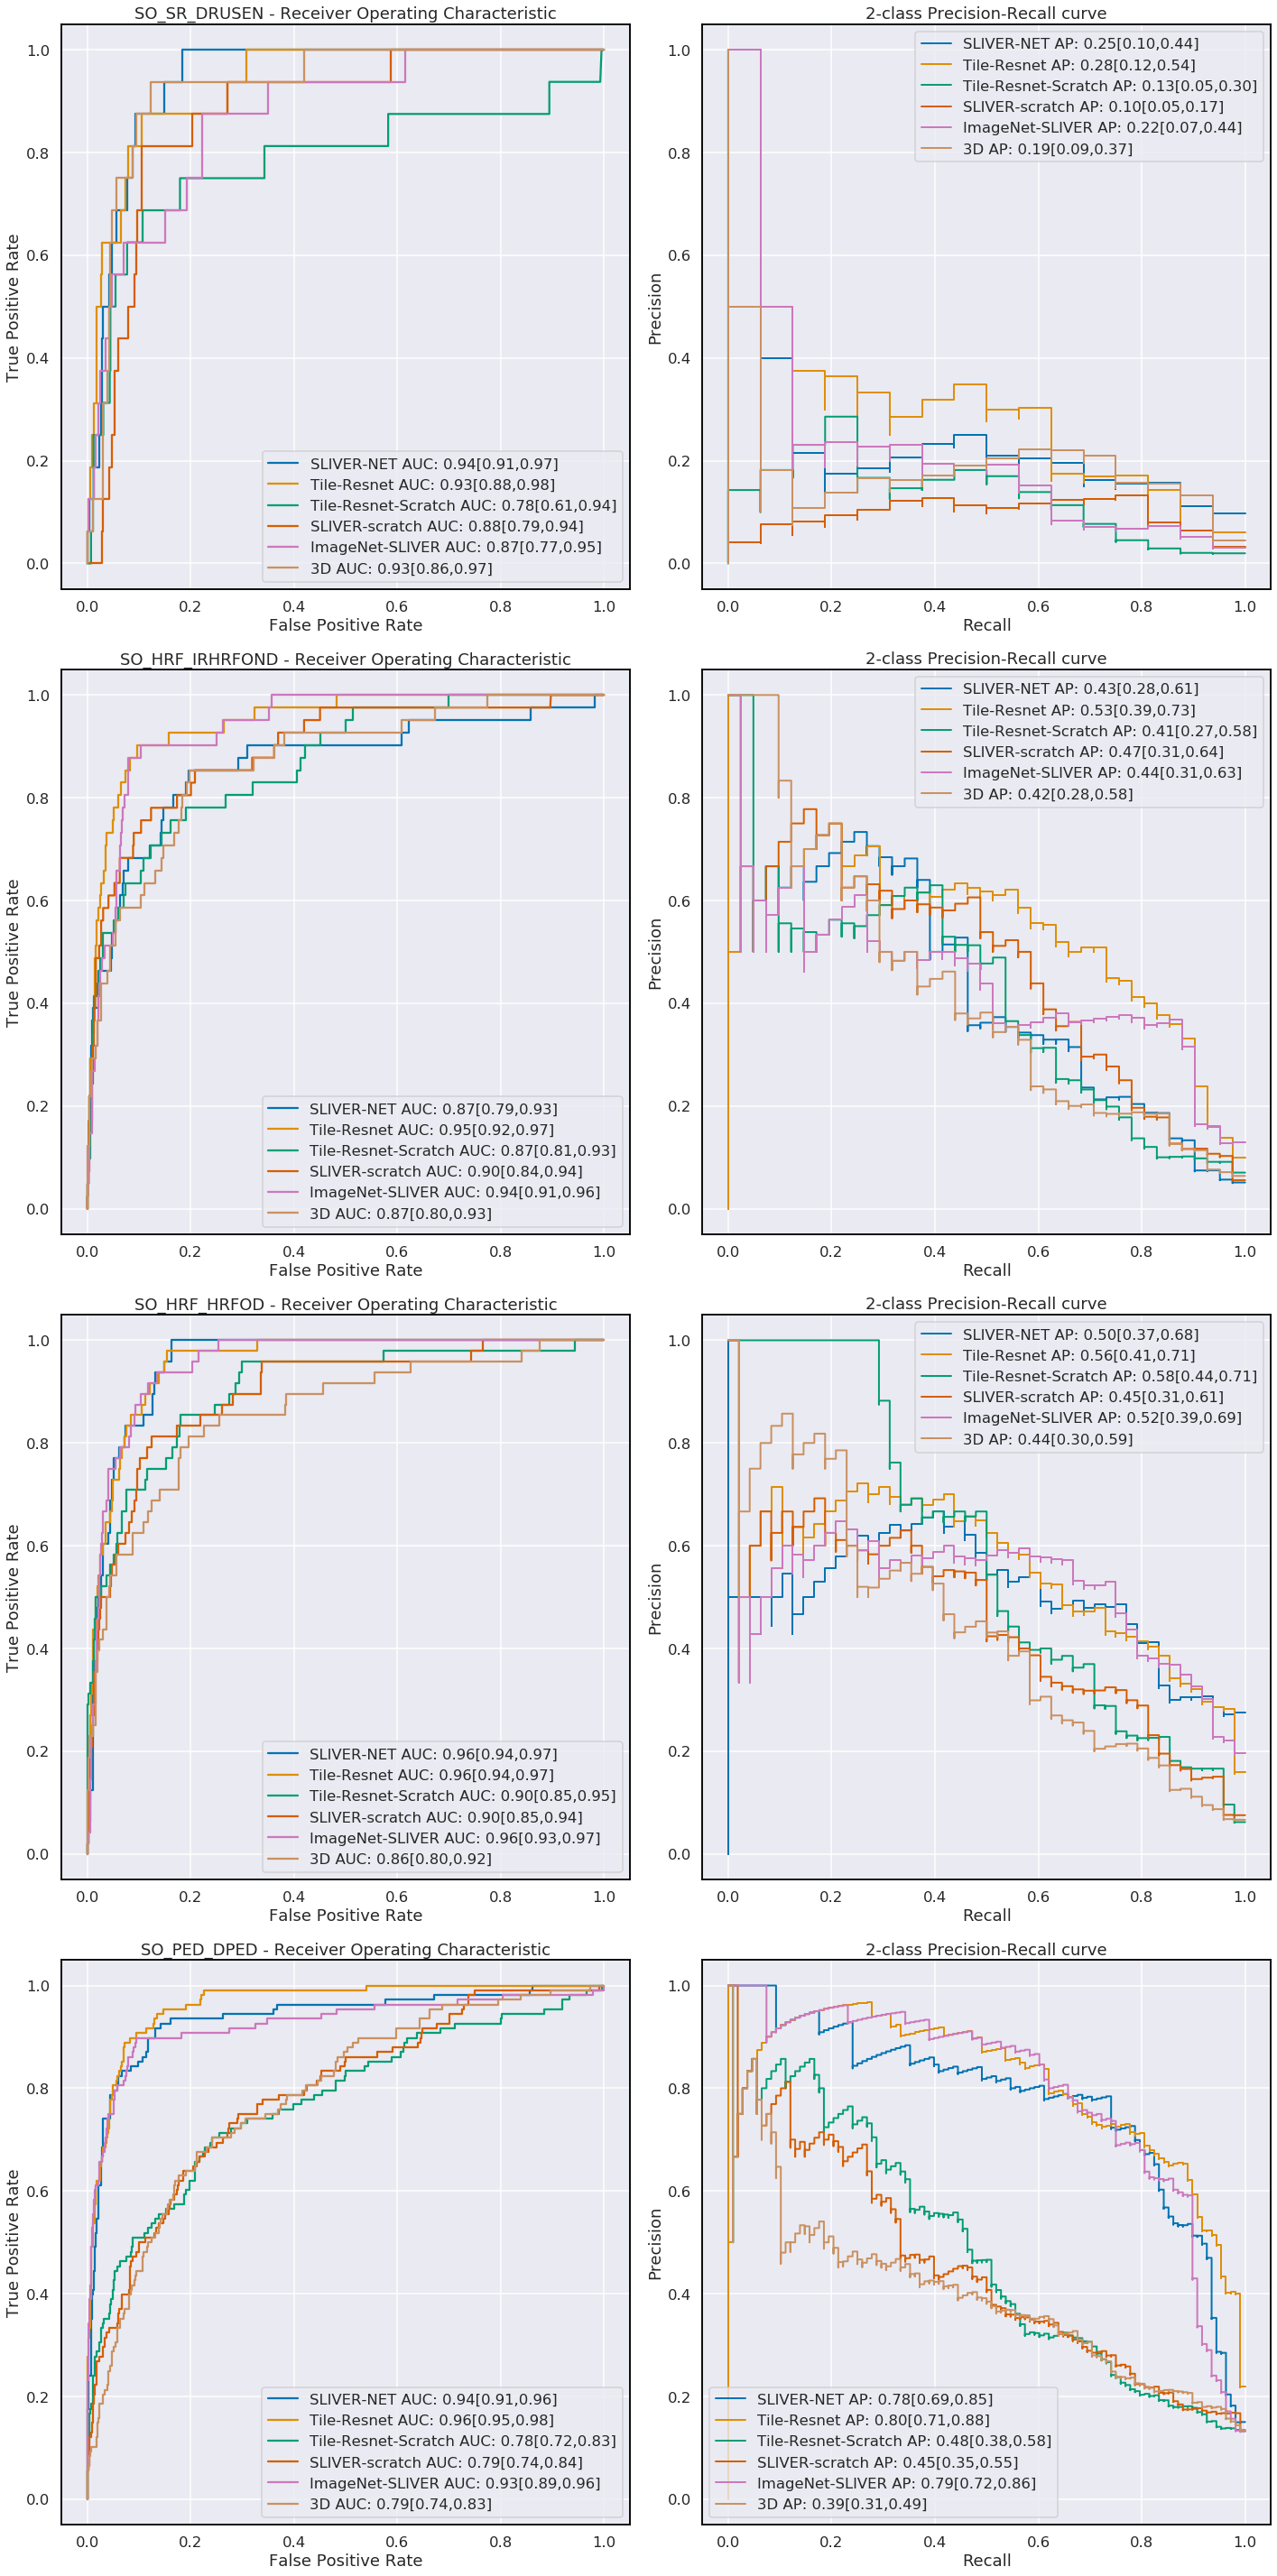

In [71]:
fig,axes = plt.subplots(len(pathologies),2,figsize=(20,10*len(pathologies)))
axes=axes.ravel()
ci_dicts = []

for i,p in enumerate(pathologies):
    y_pred = results[p]['y_pred']
    y_true = results[p]['y_true']

    print(p)
    _,ci_dict,res_dict = print_ci(preds_names,
                   y_pred=np.array(y_pred).T,y_true=np.array(y_true).T,plot=True,ax = axes[2*i],ax2=axes[2*i+1],
                   title = f'{p} - Receiver Operating Characteristic',t_test=True,iter=1000)
    
    
    ci_dicts.append(ci_dict)
    
fig.tight_layout()

#### wo tfms

In [90]:
PLOT = False

if(PLOT):
    fig,axes = plt.subplots(len(pathologies),2,figsize=(20,10*len(pathologies)))
    axes=axes.ravel()
    
ci_dicts = []
res_dicts = []

for i,p in enumerate(pathologies):
    y_pred = results[p]['y_pred']
    y_true = results[p]['y_true']

    print(p)
    _,ci_dict,res_dict = print_ci(preds_names,
                   y_pred=np.array(y_pred).T,y_true=np.array(y_true).T,plot=PLOT,ax = axes[2*i],ax2=axes[2*i+1],
                   title = f'{p} - Receiver Operating Characteristic',t_test=True,iter=1000)
    
    
    ci_dicts.append(ci_dict)
    res_dicts.append(res_dict)
    
    

print('\n','CALCULATE SUMMERY STATS','\n','===================','\n')
print('Model','Median AUROC','Median AUPRC','ROC p-val','PR p-val',sep='\t')
meta_data = []
bl_roc,bl_pr=None,None

for i,m_name in enumerate(preds_names):
    md = MedianCI(m_name,res_dicts,pathologies,verbose=True,bl_roc=bl_roc,bl_pr=bl_pr)
    if(i==0): bl_roc,bl_pr = md[2],md[3]
        
    meta_data.append(md)
    
fig.tight_layout()

SO_SR_DRUSEN
Model	ROC	PR	ROC P-Value	PR P-Value
3D_CNN 	0.83[0.70,0.94] 	0.11[0.06,0.23] 	Baseline 	Baseline
SLIVER-NET 	0.94[0.91,0.97] 	0.22[0.11,0.41] 	0.011 	0.056
SO_HRF_IRHRFOND
Model	ROC	PR	ROC P-Value	PR P-Value
3D_CNN 	0.78[0.71,0.85] 	0.25[0.14,0.40] 	Baseline 	Baseline
SLIVER-NET 	0.92[0.89,0.96] 	0.50[0.35,0.69] 	0.001 	0.001
SO_HRF_HRFOD
Model	ROC	PR	ROC P-Value	PR P-Value
3D_CNN 	0.78[0.70,0.85] 	0.27[0.16,0.40] 	Baseline 	Baseline
SLIVER-NET 	0.91[0.85,0.95] 	0.42[0.31,0.59] 	0.002 	0.024
SO_PED_DPED
Model	ROC	PR	ROC P-Value	PR P-Value
3D_CNN 	0.67[0.61,0.73] 	0.31[0.23,0.40] 	Baseline 	Baseline
SLIVER-NET 	0.94[0.90,0.97] 	0.83[0.76,0.89] 	0.001 	0.001

 CALCULATE SUMMERY STATS 

Model	Median AUROC	Median AUPRC	ROC p-val	PR p-val
3D_CNN              	0.78[0.72,0.82]	0.26[0.19,0.33]	Baseline	Baseline
SLIVER-NET          	0.93[0.91,0.95]	0.46[0.37,0.58]	0.00	0.00


In [41]:
PLOT = False

if(PLOT):
    fig,axes = plt.subplots(len(pathologies),2,figsize=(20,10*len(pathologies)))
    axes=axes.ravel()
    
ci_dicts = []
res_dicts = []

for i,p in enumerate(pathologies):
    y_pred = results[p]['y_pred']
    y_true = results[p]['y_true']

    print(p)
    _,ci_dict,res_dict = print_ci(preds_names,
                   y_pred=np.array(y_pred).T,y_true=np.array(y_true).T,plot=PLOT,ax = axes[2*i],ax2=axes[2*i+1],
                   title = f'{p} - Receiver Operating Characteristic',t_test=True,iter=1000)
    
    
    ci_dicts.append(ci_dict)
    res_dicts.append(res_dict)
    
    

print('\n','CALCULATE SUMMERY STATS','\n','===================','\n')
print('Model','Median AUROC','Median AUPRC','ROC p-val','PR p-val',sep='\t')
meta_data = []
bl_roc,bl_pr=None,None

for i,m_name in enumerate(preds_names):
    md = MedianCI(m_name,res_dicts,pathologies,verbose=True,bl_roc=bl_roc,bl_pr=bl_pr)
    if(i==0): bl_roc,bl_pr = md[2],md[3]
        
    meta_data.append(md)
    
fig.tight_layout()

SO_SR_DRUSEN
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-NET 	0.88[0.77,0.96] 	0.22[0.10,0.39] 	Baseline 	Baseline
SO_HRF_IRHRFOND
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-NET 	0.94[0.91,0.96] 	0.52[0.38,0.67] 	Baseline 	Baseline
SO_HRF_HRFOD
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-NET 	0.95[0.91,0.97] 	0.56[0.41,0.72] 	Baseline 	Baseline
SO_PED_DPED
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-NET 	0.92[0.89,0.95] 	0.75[0.68,0.82] 	Baseline 	Baseline

 CALCULATE SUMMERY STATS 

Model	Median AUROC	Median AUPRC	ROC p-val	PR p-val
SLIVER-NET          	0.93[0.91,0.95]	0.54[0.43,0.64]	Baseline	Baseline


NameError: name 'fig' is not defined

In [18]:
def ci2errs(vals,ci):
    return np.abs(np.array(ci).T - np.array(vals))

# External set

## load data 

In [38]:
local_path = Path('./')

In [39]:
ext_dfs_eval = []
ext_dfs_eval_names = []
ext_files = [i for i in local_path.iterdir() if 'ext_qc' in i.name]

for f in ext_files:
    if('MGN' in f.name): continue
    print(f.name)
    ext_df = pd.read_csv(f,index_col=0)
    ext_df['CASE_ID_SHORT'] = ext_df.CASE_ID.apply(lambda x: x[:9])
    ext_df = validateNumerical(ext_df)
#     ext_df['CO_Drusen_Core_OD'] = ext_df['SO_Hypo_Drusen_Core_OD']
#     ext_df['CO_Drusen_Core_OS'] = ext_df['SO_Hypo_Drusen_Core_OS']
    ext_df = ext_df.drop_duplicates(); print(ext_df.shape)
    ext_df = ext_df.sort_values('SO_SR_DRUSEN_OS').drop_duplicates(subset=['CASE_ID']);print(ext_df.shape)
    ext_df = binarizeDataFrame(ext_df,cat_cols,gold=False)
    ext_df = ext_df.set_index('CASE_ID')
    ext_dfs_eval.append(ext_df)
    ext_dfs_eval_names.append(f.name.split('_')[2])

#    if('MGN' in f.name):
#         ext_df = binarizeDataFrame(ext_df,cat_cols)
#         ext_df_gold = ext_df

AMISH_01-24-2020_Swetha_ext_qc.csv
(106, 44)
(97, 44)
AMISH_1-16-2020_GC_ext_qc.csv
(97, 43)
(97, 43)
AMISH_12-16-2019_LT_ext_qc.csv
(97, 39)
(97, 39)


In [40]:
ext_files

[PosixPath('AMISH_01-24-2020_Swetha_ext_qc.csv'),
 PosixPath('AMISH_1-16-2020_GC_ext_qc.csv'),
 PosixPath('AMISH_11-29-2019_MGN_ext_qc.csv'),
 PosixPath('AMISH_12-16-2019_LT_ext_qc.csv')]

In [92]:
print(df.columns.to_list())

['STUDY', 'SUBSTUDY', 'CENTER', 'GROUP', 'INDIVIDUAL', 'EXAM_DATE', 'EXAMINER', 'EYE', 'CO_COMMENTS_OD', 'CO_COMMENTS_OS', 'CO_ACTION_OD', 'CO_ACTION_OS', 'CO_OPTH_FINDINGS_OD', 'CO_OPTH_FINDINGS_OS', 'CO_QIMG_OD', 'CO_QIMG_OS', 'CO_RPE_A3MM_OD', 'CO_RPE_A3MM_OS', 'CO_RPE_A5MM_OD', 'CO_RPE_A5MM_OS', 'CO_RPE_V3MM_OD', 'CO_RPE_V3MM_OS', 'CO_RPE_V5MM_OD', 'CO_RPE_V5MM_OS', 'CO_GA_A5MM_OD', 'CO_GA_A5MM_OS', 'CO_SUBFOVEAL_OD', 'CO_SUBFOVEAL_OS', 'CO_SUBRETINAL_OD', 'CO_SUBRETINAL_OS', 'CO_SRTSRHRM_OD', 'CO_SRTSRHRM_OS', 'CO_INTRA_RCS_OD', 'CO_INTRA_RCS_OS', 'CO_OUTER_RT_OD', 'CO_OUTER_RT_OS', 'CO_SR_DRUSEN_OD', 'CO_SR_DRUSEN_OS', 'CO_HRF_IRHRFOND_OD', 'CO_HRF_IRHRFOND_OS', 'CO_HRF_HRFOD_OD', 'CO_HRF_HRFOD_OS', 'CO_HRF_LHRFOD_OD', 'CO_HRF_LHRFOD_OS', 'CO_PED_DPED_OD', 'CO_PED_DPED_OS', 'CO_PED_HPED_OD', 'CO_PED_HPED_OS', 'CO_PED_SEROUS_OD', 'CO_PED_SEROUS_OS', 'SO_COMMENTS_OD', 'SO_COMMENTS_OS', 'SO_ACTION_OD', 'SO_ACTION_OS', 'SO_OPTH_FINDINGS_OD', 'SO_OPTH_FINDINGS_OS', 'SO_QIMG_OD', 'SO_Q

In [37]:
for ext_df in ext_dfs_eval:
    
    print(ext_df.columns.to_list())
    print('\n\n\n')

['CENTER', 'GROUP', 'INDIVIDUAL', 'ID', 'EXAM_DATE', 'EXAMINER', 'SO_COMMENTS_OD', 'SO_COMMENTS_OS', 'SO_OPTH_FINDINGS_OD', 'SO_OPTH_FINDINGS_OS', 'SO_QIMG_OD', 'SO_QIMG_OS', 'SO_SUBFOVEAL_OD', 'SO_SUBFOVEAL_OS', 'SO_SUBRETINAL_OD', 'SO_SUBRETINAL_OS', 'SO_SRTSRHRM_OD', 'SO_SRTSRHRM_OS', 'SO_INTRA_RCS_OD', 'SO_INTRA_RCS_OS', 'SO_OUTER_RT_OD', 'SO_OUTER_RT_OS', 'SO_SR_DRUSEN_OD', 'SO_SR_DRUSEN_OS', 'SO_HRF_IRHRFOND_OD', 'SO_HRF_IRHRFOND_OS', 'SO_HRF_HRFOD_OD', 'SO_HRF_HRFOD_OS', 'SO_HRF_LHRFOD_OD', 'SO_HRF_LHRFOD_OS', 'SO_PED_DPED_OD', 'SO_PED_DPED_OS', 'SO_PED_HPED_OD', 'SO_PED_HPED_OS', 'SO_PED_SEROUS_OD', 'SO_PED_SEROUS_OS', 'SO_Hypo_Drusen_Core_OD', 'SO_Hypo_Drusen_Core_OS', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'PAT_ID', 'CASE_ID_SHORT']




['CENTER', 'GROUP', 'CENTER.1', 'GROUP.1', 'INDIVIDUAL', 'ID', 'EXAM_DATE', 'EXAMINER', 'SO_COMMENTS_OD', 'SO_COMMENTS_OS', 'SO_OPTH_FINDINGS_OD', 'SO_OPTH_FINDINGS_OS', 'SO_QIMG_OD', 'SO_QIMG_OS', 'SO_SUBFOVEAL_OD', 'SO_SUBFOVEAL_OS', '

## model parameters 

In [44]:
##'./models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn'
# compare_pathologies = ['SO_SR_DRUSEN', 'SO_HRF_IRHRFOND', 'SO_HRF_HRFOD','SO_PED_DPED']
# run_name = 'slices_upenn'

##'./models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn/'
# compare_pathologies = ['SO_SR_DRUSEN', 'SO_HRF_IRHRFOND', 'SO_HRF_HRFOD','CO_RPE_V3MM_L0.03','CO_Drusen_Core','IRP_RP']
# run_name = 'models_vasMarkers_upenn'

##'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV'
# compare_pathologies = ['SO_SR_DRUSEN', 'SO_HRF_IRHRFOND', 'SO_HRF_HRFOD','CO_RPE_V3MM_L0.03','CO_Drusen_Core','IRP_RP']
# run_name = 'models_vasMarkers_upenn_97_origCSV_newCSV'


compare_pathologies = ['SO_SR_DRUSEN', 'SO_HRF_IRHRFOND', 'SO_HRF_HRFOD','CO_RPE_V3MM_L0.03','CO_Drusen_Core','IRP_RP']
run_name = 'models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long'


p_list = '_'.join(compare_pathologies)
model_dir  =  f'models/{p_list}_vol_{run_name}' 
print(compare_pathologies)
print(model_dir)

['SO_SR_DRUSEN', 'SO_HRF_IRHRFOND', 'SO_HRF_HRFOD', 'CO_RPE_V3MM_L0.03', 'CO_Drusen_Core', 'IRP_RP']
models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long


In [45]:
fullDisplay(df[df[['CENTER']+pathologies_eyes].isna().any(axis=1)][['CENTER']+pathologies_eyes])

NameError: name 'pathologies_eyes' is not defined

## merge different annotators 

In [46]:
pathologies_eyes = [f'{p}_OD' for p in compare_pathologies] + [f'{p}_OS' for p in compare_pathologies] 
pathologies_eyes_eval = [p for p in pathologies_eyes if p in ext_dfs_eval[0].columns]

ext_dfs_combined = (df[['CENTER']+pathologies_eyes].fillna(-1)
                          .merge(ext_dfs_eval[0][pathologies_eyes_eval],left_index=True,right_index=True,suffixes=('', f'_{ext_dfs_eval_names[0]}'))
                          .merge(ext_dfs_eval[1][pathologies_eyes_eval],left_index=True,right_index=True,suffixes=('', f'_{ext_dfs_eval_names[1]}'))
                          .merge(ext_dfs_eval[2][pathologies_eyes_eval],left_index=True,right_index=True,suffixes=('', f'_{ext_dfs_eval_names[2]}'))
                        ).fillna(0.5)

ext_dfs_combined

,CENTER,SO_SR_DRUSEN_OD,SO_HRF_IRHRFOND_OD,SO_HRF_HRFOD_OD,CO_RPE_V3MM_L0.03_OD,CO_Drusen_Core_OD,IRP_RP_OD,SO_SR_DRUSEN_OS,SO_HRF_IRHRFOND_OS,SO_HRF_HRFOD_OS,...,SO_HRF_HRFOD_OD_GC,SO_SR_DRUSEN_OS_GC,SO_HRF_IRHRFOND_OS_GC,SO_HRF_HRFOD_OS_GC,SO_SR_DRUSEN_OD_LT,SO_HRF_IRHRFOND_OD_LT,SO_HRF_HRFOD_OD_LT,SO_SR_DRUSEN_OS_LT,SO_HRF_IRHRFOND_OS_LT,SO_HRF_HRFOD_OS_LT
CASE_ID,,,,,,,,,,,,,,,,,,,,,
0350_0010_08052015,UPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0228_0004_08132015,UPEN,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,...,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
0307_0006_08132015,UPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
0269_0008_10012015,UPEN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
0327_0005_10222015,UPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0077_0004_05122016,UPEN,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
0077_0009_05122016,UPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0079_0003_05122016,UPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## filter test site files to match annotators 

In [47]:
isInAmishDf = partial(isInDf,df=ext_dfs_combined)
areValidpathologiesLabels = partial(areValidLabels,pathologies=compare_pathologies,df=ext_dfs_combined)
isValidLabelPathology =  partial(isValidLabel,pathology=compare_pathologies)
areValidCovLabels = partial(areValidLabels,pathologies=covariants,df=ext_dfs_combined)

## create test set run parameters 

In [48]:
EPOCHS =  50
slices=97
BATCH = 8
do_tfms = False
rotation = (-5,5)
ncov = 0 if covariants is None else 2
Train=False

ds_comp_params = {
    'df':ext_dfs_combined,
    'pathologies':compare_pathologies,
    'n_workers':-1,
    'resize':(256,256),
    'rcrop_size':(224,224),
    'rotation':rotation,
    'do_transform':do_tfms,
    'unif_transform':True,
    'contrast':True,
    'hflip':True,
    'n_slices':slices, 
    'tiled':True,
    'classification':True,
    'data_type':data_type,
    'cov': covariants
    }

criterion = torch.nn.BCEWithLogitsLoss()
work_path = Path('/opt/data/workingdir/nrakocz/oct/')


In [49]:
ds_tst = AmishVolumeDataset(test_files_list,**ds_comp_params,mode='test')

ds_tst = (ds_tst.filter_by_func(isInAmishDf)
        .filter_by_func(lambda f: 'Unknown' not in f.name)
        .filter_by_func(lambda f: 'ERROR' not in f.name)
        .filter_by_func(areValidpathologiesLabels)
         )

tst_dl = torch.utils.data.DataLoader(ds_tst, batch_size=BATCH,num_workers=22,drop_last=False)
data_tst = DataBunch(train_dl=tst_dl, valid_dl=tst_dl)
data_tst.c = len(compare_pathologies) # must match the model loaded

len(ds_tst)

182

In [46]:
ds_tst[163]

(tensor([[[0.0314, 0.0667, 0.0667,  ..., 0.0667, 0.0157, 0.0000],
          [0.1176, 0.0980, 0.0980,  ..., 0.0471, 0.0157, 0.0000],
          [0.0667, 0.0314, 0.0471,  ..., 0.0157, 0.0157, 0.0314],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.0314, 0.0667, 0.0667,  ..., 0.0667, 0.0157, 0.0000],
          [0.1176, 0.0980, 0.0980,  ..., 0.0471, 0.0157, 0.0000],
          [0.0667, 0.0314, 0.0471,  ..., 0.0157, 0.0157, 0.0314],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.0314, 0.0667, 0.0667,  ..., 0.0667, 0.0157, 0.0000],
          [0.1176, 0.0980, 0.0980,  ..., 0.0471, 0.0157, 0.0000],
          [0.0667, 0.0314, 0.0471,  ...,

## Load trained learner (model) 

In [58]:
model_name = 'SLIVER-NET'
learn_tst = getArch(model_name,
            data=data_tst,
            loss_func=criterion,
            path=work_path,
            model_dir=model_dir,
            multi_gpu=False,
            ds_params=ds_comp_params)

In [59]:
learn_tst.load('resnet18_SLIVER-NET')

Learner(data=DataBunch;

Train: <exp.nb_AmishDataLoaders.AmishVolumeDataset object at 0x7f50cb2fdb90>;

Valid: <exp.nb_AmishDataLoaders.AmishVolumeDataset object at 0x7f50cb2fdb90>;

Test: None, model=covModel(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## predict and calculate metrics 

In [60]:
y_pred,y_true = learn_tst.get_preds()
y_pred_num = y_pred.data.numpy()
y_true_num = y_true.data.numpy().astype(int)


for p_i,p in enumerate(compare_pathologies):
    
    i_valid = y_true_num[:,p_i]!=-1
    y_true_num_valid = y_true_num[i_valid,p_i]
    y_pred_num_valid = y_pred_num[i_valid,p_i]
    
    _,_,_ = print_ci(['model'],y_pred=y_pred_num_valid,y_true=y_true_num_valid,
                       plot=False,ax = None,ax2=None,
                       title = f'{p} - Receiver Operating Characteristic',t_test=False,iter=1000)
    
    roc_score = roc_auc_score(y_true_num_valid,y_pred_num_valid)
    pr_score = average_precision_score(y_true_num_valid,y_pred_num_valid)
    print(f'{p}\n')
    
    
repro_pred_output = os.path.join(learn_tst.path,'repro_preds', f"{run_name}_repro_preds.csv")    
pd.DataFrame(np.concatenate((y_pred_num,y_true_num),axis=1),
             columns=compare_pathologies + [f'{p}_gt' for p in compare_pathologies],
             index=[i[0].name for i in ds_tst.items]
            ).to_csv(repro_pred_output)

Model	ROC	PR	ROC P-Value	PR P-Value
model 	0.99[0.99,1.00] 	0.84[0.83,1.00] 	 	
SO_SR_DRUSEN

Model	ROC	PR	ROC P-Value	PR P-Value
model 	0.97[0.94,0.99] 	0.52[0.22,0.80] 	 	
SO_HRF_IRHRFOND

Model	ROC	PR	ROC P-Value	PR P-Value
model 	0.96[0.91,0.99] 	0.49[0.24,0.88] 	 	
SO_HRF_HRFOD

Model	ROC	PR	ROC P-Value	PR P-Value
model 	1.00[1.00,1.00] 	0.93[0.92,1.00] 	 	
CO_RPE_V3MM_L0.03

Model	ROC	PR	ROC P-Value	PR P-Value
model 	0.83[0.72,0.92] 	0.12[0.04,0.30] 	 	
CO_Drusen_Core

Model	ROC	PR	ROC P-Value	PR P-Value
model 	0.98[0.98,1.00] 	0.71[0.72,1.00] 	 	
IRP_RP



In [53]:
y_pred,y_true = learn_tst.get_preds()
y_pred_num = y_pred.data.numpy()
y_true_num = y_true.data.numpy().astype(int)


for p_i,p in enumerate(compare_pathologies):
    
    i_valid = y_true_num[:,p_i]!=-1
    y_true_num_valid = y_true_num[i_valid,p_i]
    y_pred_num_valid = y_pred_num[i_valid,p_i]
    
    _,_,_ = print_ci(['SLIVER-net'],y_pred=y_pred_num_valid,y_true=y_true_num_valid,
                       plot=False,ax = None,ax2=None,
                       title = f'{p} - Receiver Operating Characteristic',t_test=False,iter=1000)
    
    roc_score = roc_auc_score(y_true_num_valid,y_pred_num_valid)
    pr_score = average_precision_score(y_true_num_valid,y_pred_num_valid)
    print(f'{p}\n')
    
    
repro_pred_output = os.path.join(learn_tst.path,'repro_preds', f"{run_name}_repro_preds.csv")    
pd.DataFrame(np.concatenate((y_pred_num,y_true_num),axis=1),
             columns=compare_pathologies + [f'{p}_gt' for p in compare_pathologies],
             index=[i[0].name for i in ds_tst.items]
            ).to_csv(repro_pred_output)

Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-net 	0.96[0.94,0.99] 	0.28[0.11,0.54] 	 	
SO_SR_DRUSEN	0.959	0.28
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-net 	0.93[0.86,0.98] 	0.42[0.13,0.74] 	 	
SO_HRF_IRHRFOND	0.934	0.42
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-net 	0.94[0.86,1.00] 	0.72[0.41,0.96] 	 	
SO_HRF_HRFOD	0.943	0.72
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-net 	1.00[0.99,1.00] 	0.96[0.79,1.00] 	 	
CO_RPE_V3MM_L0.03	0.998	0.96
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-net 	0.77[0.71,0.96] 	0.34[0.13,0.76] 	 	
CO_Drusen_Core	0.774	0.34
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-net 	0.97[0.97,0.98] 	0.43[0.44,0.60] 	 	
IRP_RP	0.971	0.43


In [55]:
repro_pred_output

'/opt/data/workingdir/nrakocz/oct/repro_preds/models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_repro_preds.csv'

In [56]:
_ = learn_tst.destroy()
import gc; gc.collect()
torch.cuda.empty_cache()

this Learner object self-destroyed - it still exists, but no longer usable


In [ ]:
for i,p in enumerate(compare_pathologies):
    y_pred = results[p]['y_pred']
    y_true = results[p]['y_true']

    print(p)
    _,ci_dict,res_dict = print_ci(preds_names,
                   y_pred=np.array(y_pred).T,y_true=np.array(y_true).T,plot=False,ax = None,ax2=None,
                   title = f'{p} - Receiver Operating Characteristic',t_test=False,iter=100)
    

# Slices

## get file names 

### Recent run 

In [152]:
#run_name = 'models_vasMarkers_upenn_97_origCSV_newCSV'
#run_name = 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices'
run_pathologies =  pathologies.copy()
# run_pathologies = ['SO_SR_DRUSEN','SO_HRF_IRHRFOND','SO_HRF_HRFOD','CO_RPE_V3MM_L0.03','CO_Drusen_Core','IRP_RP'] 


p_list = '_'.join(run_pathologies)
model_dir  = f'models/{run_pathologies}_vol_{run_name}' if(type(run_pathologies) != list) else f'models/{p_list}_vol_{run_name}'

print(run_name)
print(model_dir)

models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items
models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items


In [155]:
key_word = 'preds' #'scratch'

preds_fl = [str(i) for i in Path(model_dir).iterdir() if('preds' in i.name)]
preds_fl = [i for i in preds_fl if key_word in i]

#---- slices
nslice_l = [int(i.split('_')[-5]) for i in preds_fl]
#---- resoluution
# nslice_l = [int(i.split('_')[-4][1:]) for i in preds_fl]
# nslice_l = [2*np.ceil((97//2+1)/slice_res)-1 for slice_res in dsamp_l]
#---- sample siaze
nslice_l = [int(i.split('_')[-8]) for i in preds_fl]

preds_fl,nslice_l

(['models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_200_items_d1_97_slices_preds_022120_1630',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_400_items_d1_97_slices_preds_022120_1659',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_600_items_d1_97_slices_preds_022120_1735',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_800_items_d1_97_slices_preds_022120_1827',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_

### previous run 

In [204]:
run_pathologies =  pathologies.copy()
# run_pathologies = ['SO_SR_DRUSEN','SO_HRF_IRHRFOND','SO_HRF_HRFOD','CO_RPE_V3MM_L0.03','CO_Drusen_Core','IRP_RP'] 


run_name = 'models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices'
# run_name = 'models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices_dsamp'
# run_name = 'models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items'

#-------------------------------------
p_list = '_'.join(run_pathologies)
model_dir  = f'models/{run_pathologies}_vol_{run_name}' if(type(run_pathologies) != list) else f'models/{p_list}_vol_{run_name}'

print(run_name)
print(model_dir)

[str(i) for i in Path(model_dir).iterdir() if('preds' in i.name)]


models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices
models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices


['models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_97_slices_preds_021720_2349',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_91_slices_preds_021820_0032',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_85_slices_preds_021820_0117',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_79_slices_preds_021820_0158',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER

In [247]:
###---- slices
x_name = r'Field of view around the macula [${\mu}m$]' #'Number of slices used for prediction'

preds_fl = ['models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_97_slices_preds_021720_2349',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_91_slices_preds_021820_0032',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_85_slices_preds_021820_0117',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_79_slices_preds_021820_0158',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_73_slices_preds_021820_0238',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_67_slices_preds_021820_0312',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_61_slices_preds_021820_0346',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_55_slices_preds_021820_0418',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_49_slices_preds_021820_0444',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_43_slices_preds_021820_0510',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_37_slices_preds_021820_0533',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_31_slices_preds_021820_0554',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_25_slices_preds_021820_0612',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_19_slices_preds_021820_0627',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_13_slices_preds_021820_0639',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices/resnet18_SLIVER-NET_9_slices_preds_021820_0648']

nslice_l = [int(i.split('_')[-5]) for i in preds_fl]
nslice_l = [(i-1)*61 for i in nslice_l]

###---- resolution
# x_name = 'Distance between adjacent slices [micron]'

# preds_fl = ['models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices_dsamp/resnet18_SLIVER-NET_97_slices_d1_preds_022120_0112',
#  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices_dsamp/resnet18_SLIVER-NET_97_slices_d2_preds_022120_1102',
#  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices_dsamp/resnet18_SLIVER-NET_97_slices_d3_preds_022120_1123',
#  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices_dsamp/resnet18_SLIVER-NET_97_slices_d4_preds_022120_1141',
#  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices_dsamp/resnet18_SLIVER-NET_97_slices_d7_preds_022120_1153',
#  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices_dsamp/resnet18_SLIVER-NET_97_slices_d9_preds_022120_1203',
#  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices_dsamp/resnet18_SLIVER-NET_97_slices_d5_preds_022120_1344',
#  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices_dsamp/resnet18_SLIVER-NET_97_slices_d8_preds_022120_1408',
#  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_slices_dsamp/resnet18_SLIVER-NET_97_slices_d6_preds_022120_1425']

# nslice_l = [int(i.split('_')[-4][1:]) for i in preds_fl]
# # nslice_l = [2*np.ceil((97//2+1)/slice_res)-1 for slice_res in nslice_l]
# nslice_l = [61*i for i in nslice_l]
# preds_fl.sort(key=lambda i:int(i.split('_')[-4][1:]))
# nslice_l.sort()




##---- sample siaze

x_name = 'Number of OCT volumes usued for training SLIVER-net'

preds_fl = [
    'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_200_items_d1_97_slices_preds_022120_1630',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_400_items_d1_97_slices_preds_022120_1659',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_600_items_d1_97_slices_preds_022120_1735',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_800_items_d1_97_slices_preds_022120_1827',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_1000_items_d1_97_slices_preds_022120_1923',
 'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_1200_items_d1_97_slices_preds_022120_2029']
nslice_l = [int(i.split('_')[-8]) for i in preds_fl]

preds_fl = ['/opt/data/workingdir/jnchiang/share/oct/3d_cnn_final/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_3dcnn_vasMarkers_upenn/resnet18_3D_CNN_97_slices_preds_020720_1053'] + preds_fl
nslice_l = ['3D CNN'] + nslice_l



nslice_l,preds_fl

(['3D CNN', 200, 400, 600, 800, 1000, 1200],
 ['/opt/data/workingdir/jnchiang/share/oct/3d_cnn_final/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_3dcnn_vasMarkers_upenn/resnet18_3D_CNN_97_slices_preds_020720_1053',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_200_items_d1_97_slices_preds_022120_1630',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_400_items_d1_97_slices_preds_022120_1659',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_600_items_d1_97_slices_preds_022120_1735',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drus

In [185]:
preds_fl.sort(key=lambda i:int(i.split('_')[-5]))
# preds_fl.sort(key=lambda i:int(i.split('_')[-4][1:]))

nslice_l.sort()
# nslice_l = [f'{61*i}' for i in nslice_l]

ValueError: invalid literal for int() with base 10: 'slices'

In [156]:
nslice_l,preds_fl

([200, 400, 600, 800, 1000, 1200],
 ['models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_200_items_d1_97_slices_preds_022120_1630',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_400_items_d1_97_slices_preds_022120_1659',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_600_items_d1_97_slices_preds_022120_1735',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_models_vasMarkers_upenn_97_origCSV_newCSV_wFreeze_long_items/resnet18_SLIVER-NET_800_items_d1_97_slices_preds_022120_1827',
  'models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_

## Load results 

In [213]:
results = {p:{'y_pred':[],'y_true':[]} for p in pathologies}

for f_path in preds_fl:
    with open(f_path,'rb') as f:
        y_dict = pickle.load(f)
        for i,p in enumerate(pathologies):
            results[p]['y_pred'].append((y_dict['y_pred'][:,i]))
            results[p]['y_true'].append((y_dict['y_true'][:,i]))

In [192]:
pathologies_names = {
    'SO_SR_DRUSEN':'Subretinal Drusenoid Deposits',
    'SO_HRF_IRHRFOND':'Hyperreflective Feature Over Non-drusen',
    'SO_HRF_HRFOD':'Hyperreflective Feature Over Drusen',
    'CO_RPE_V3MM_L0.03':'Drusen Volume > 3mm',
    'IRP_RP':'Reticular Pseudodrusen',
    'CO_Drusen_Core':'HF Drusen Core'
}

In [ ]:
PLOT = False
COMBINE_HYPER = True
SUM_STAT_MEDIAN = False
BOOTSTRAP_ITTER = 5000

ci_dicts = []
res_dicts = []

for i,p in enumerate(run_pathologies):
    if((p in hyper_features) and COMBINE_HYPER): continue
    y_pred = results[p]['y_pred']
    y_true = results[p]['y_true']

    print(p)
    _,ci_dict,res_dict = print_ci(preds_names,
                   y_pred=np.array(y_pred).T,y_true=np.array(y_true).T,plot=PLOT,ax = axes[2*i],ax2=axes[2*i+1],
                   title = f'{p} - Receiver Operating Characteristic',t_test=True,iter=BOOTSTRAP_ITTER)


    ci_dicts.append(ci_dict)
    res_dicts.append(res_dict)

#==========================================
# Callculate CI & P-val for hyper feautres
#==========================================
if(COMBINE_HYPER):
    print(hyper_name)
    HRF_IRHRFOND_pred = np.array(results['SO_HRF_IRHRFOND']['y_pred']).T
    HRF_IRHRFOND_true = np.array(results['SO_HRF_IRHRFOND']['y_true']).T
    HRF_HRFOD_pred = np.array(results['SO_HRF_HRFOD']['y_pred']).T
    HRF_HRFOD_true = np.array(results['SO_HRF_HRFOD']['y_true']).T

    hrf_pred = np.max(np.stack((HRF_IRHRFOND_pred,HRF_HRFOD_pred),axis=2),axis=2)
    hrf_true = np.max(np.stack((HRF_IRHRFOND_true,HRF_HRFOD_true),axis=2),axis=2)

    results[hyper_name]['y_pred'] = hrf_pred
    results[hyper_name]['y_true'] = hrf_true

    _,ci_dict,res_dict = print_ci(preds_names,
                       y_pred=hrf_pred,y_true=hrf_true,plot=PLOT,ax = axes[2*i],ax2=axes[2*i+1],
                       title = f'{hyper_name} - Receiver Operating Characteristic',t_test=True,iter=BOOTSTRAP_ITTER)


    ci_dicts.append(ci_dict)
    res_dicts.append(res_dict)


#=================================
#Print Summary stats
#=================================

print('\n','CALCULATE SUMMERY STATS','\n','===================','\n')

print('Model','Median AUROC','Median AUPRC','ROC p-val','PR p-val',sep='\t')
sum_stats_pathologies = plot_pathologies if(COMBINE_HYPER) else run_pathologies
meta_data = []
bl_roc,bl_pr=None,None

for i,m_name in enumerate(preds_names):
    md = MedianCI(m_name,res_dicts,sum_stats_pathologies,verbose=True,bl_roc=bl_roc,bl_pr=bl_pr,median=SUM_STAT_MEDIAN)
    if(i==0): bl_roc,bl_pr = md[2],md[3]

    meta_data.append(md)

if(PLOT): fig.tight_layout()

## Plot 

SO_SR_DRUSEN
Model	ROC	PR	ROC P-Value	PR P-Value
3D CNN 	0.79[0.62,0.92] 	0.08[0.04,0.21] 	Baseline 	Baseline
200 	0.89[0.80,0.95] 	0.15[0.06,0.35] 	0.02 	0.038
400 	0.94[0.88,0.98] 	0.35[0.13,0.60] 	0.001 	0.002
600 	0.93[0.87,0.97] 	0.15[0.07,0.29] 	0.003 	0.086
800 	0.95[0.91,0.98] 	0.38[0.15,0.66] 	0.003 	0.017
1000 	0.96[0.93,0.98] 	0.31[0.13,0.61] 	0.002 	0.026
1200 	0.96[0.93,0.98] 	0.34[0.13,0.61] 	0.001 	0.009
SO_HRF_IRHRFOND
Model	ROC	PR	ROC P-Value	PR P-Value
3D CNN 	0.71[0.59,0.81] 	0.18[0.08,0.35] 	Baseline 	Baseline
200 	0.93[0.87,0.97] 	0.43[0.28,0.65] 	0.001 	0.001
400 	0.94[0.89,0.97] 	0.46[0.30,0.64] 	0.001 	0.003
600 	0.93[0.90,0.96] 	0.36[0.22,0.52] 	0.001 	0.027
800 	0.93[0.88,0.97] 	0.44[0.26,0.62] 	0.001 	0.001
1000 	0.94[0.92,0.97] 	0.43[0.27,0.61] 	0.001 	0.008
1200 	0.92[0.86,0.97] 	0.48[0.30,0.66] 	0.001 	0.001
SO_HRF_HRFOD
Model	ROC	PR	ROC P-Value	PR P-Value
3D CNN 	0.72[0.63,0.81] 	0.22[0.12,0.37] 	Baseline 	Baseline
200 	0.91[0.86,0.95] 	0.38[0.26,0.56] 	0

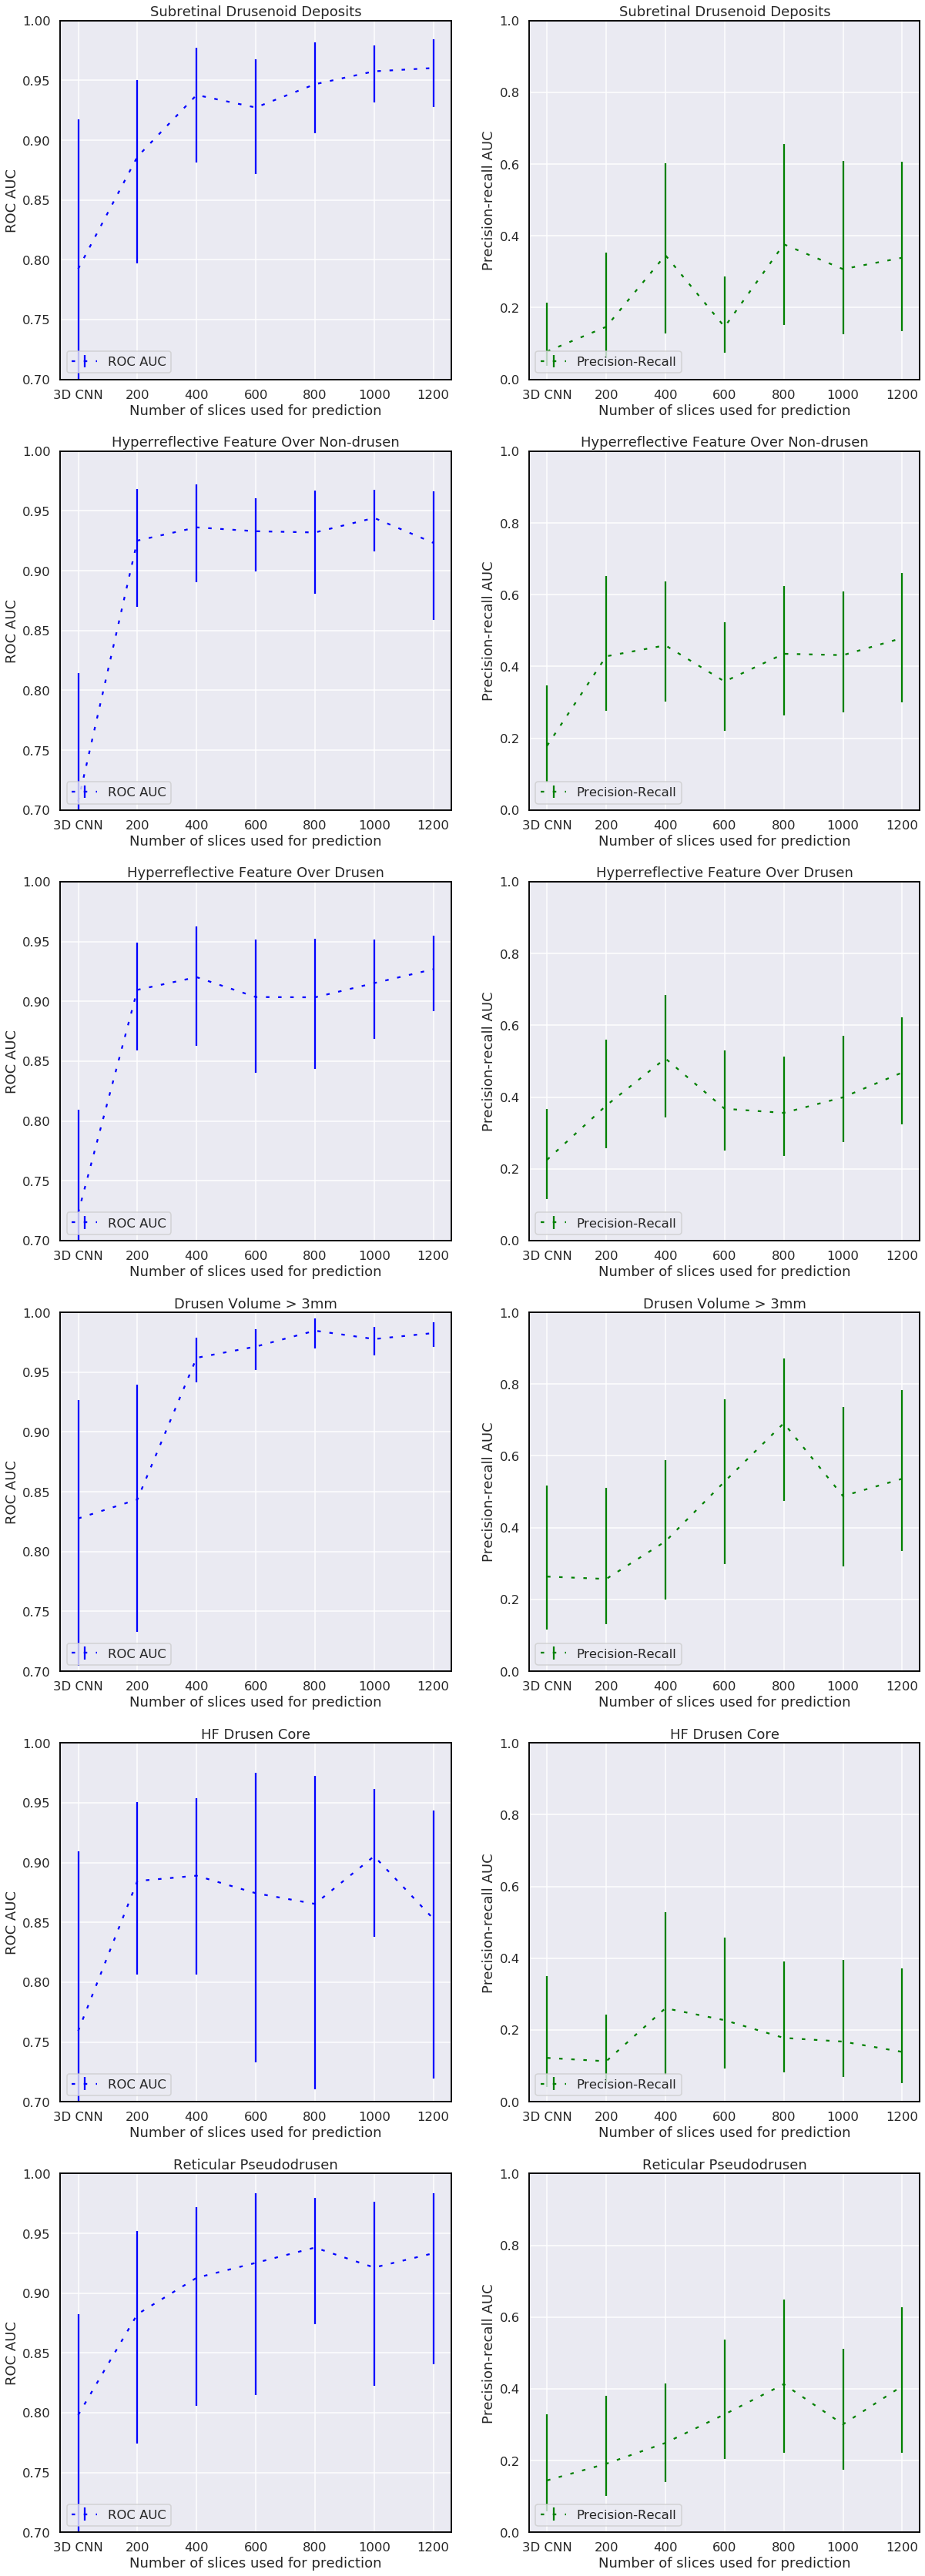

In [217]:
fig,axes = plt.subplots(len(pathologies),2,figsize=(20,10*len(pathologies)))
axes=axes.ravel()
ci_dicts = []
COMBINE_HYPER = False
ci_dicts = []
res_dicts = []
SUM_STAT_MEDIAN = False
pred_items = nslice_l

for i,p in enumerate(pathologies):
    y_pred = results[p]['y_pred']
    y_true = results[p]['y_true']

    print(p)
    _,ci_dict,res_dict = print_ci(nslice_l,
                   y_pred=np.array(y_pred).T,y_true=np.array(y_true).T,plot=False,ax = axes[2*i],ax2=axes[2*i+1],
                   title = f'{p} - Receiver Operating Characteristic',t_test=True,iter=1000)
    
    ci_dicts.append(ci_dict)
    res_dicts.append(res_dict)
    
    rocs,rocs_ci,prs,prs_ci = [],[],[],[]
    for ns,(roc_ci,pr_ci) in ci_dict.items():
        roc,roc_l,roc_h = roc_ci
        rocs.append(roc)
        rocs_ci.append((roc_l,roc_h))      
        pr,pr_l,pr_h = pr_ci
        prs.append(pr)
        prs_ci.append((pr_l,pr_h))

    rocs_errs = ci2errs(rocs,rocs_ci)
    prs_errs = ci2errs(prs,prs_ci)

    
    axes[i*2].errorbar([str(s) for s in nslice_l], rocs, yerr=rocs_errs, label='ROC AUC',color='b',linestyle=(0,(2,5)))#"None"
    axes[i*2].set_ylim(0.7,1)
    axes[i*2+1].errorbar([str(s) for s in nslice_l], prs, yerr=prs_errs, label='Precision-Recall',color='g',linestyle=(0,(2,5)))
    axes[i*2+1].set_ylim(0,1)
    
    axes[i*2].set_title(pathologies_names[p]); axes[i*2].set_ylabel('ROC AUC'); axes[i*2].legend(loc='lower left');
    axes[i*2+1].set_title(pathologies_names[p]);  axes[i*2+1].set_ylabel('Precision-recall AUC'); axes[i*2+1].legend(loc='lower left');
    axes[i*2+1].set_xlabel('Number of slices used for prediction')
    axes[i*2].set_xlabel('Number of slices used for prediction')
#     axes[i*2].set_xlabel('Distance between adjacent slices [micron]')
#     axes[i*2+1].set_xlabel('Distance between adjacent slices [micron]')
    
    fig.savefig('tmp.png')
    
print('Model','Median AUROC','Median AUPRC','ROC p-val','PR p-val',sep='\t')
sum_stats_pathologies = plot_pathologies if(COMBINE_HYPER) else run_pathologies
meta_data = []
bl_roc,bl_pr=None,None

for i,m_name in enumerate(pred_items):
    md = MedianCI(m_name,res_dicts,sum_stats_pathologies,verbose=True,bl_roc=bl_roc,bl_pr=bl_pr,median=SUM_STAT_MEDIAN)
    if(i==0): bl_roc,bl_pr = md[2],md[3]

    meta_data.append(md)    


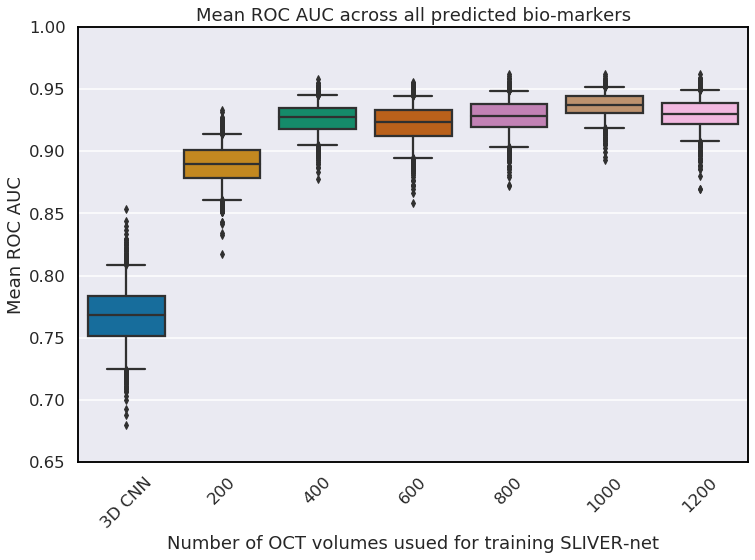

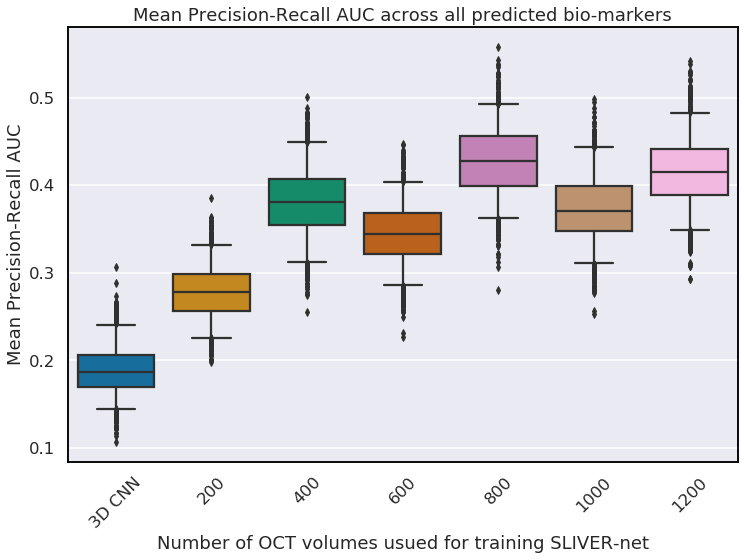

In [248]:
plt_pre = x_name.split(' ')[0]

for i,met in [(2,'ROC'),(3,'Precision-Recall')]:
    df_dict = {}
    y_name = f'Mean {met} AUC'
    
    fig,ax = plt.subplots(figsize=(12,8))


    for m,name in zip(meta_data,pred_items):
        name=f'{name}'
        df_dict[name]=m[i]


    bx_df = pd.DataFrame(df_dict)
    bx_df = pd.melt(bx_df,var_name=x_name,value_name=y_name)

    sns.boxplot(data = bx_df,x=x_name,y=y_name,ax=ax,whis=[5, 95],)
    ax.set_title(f'{y_name} across all predicted bio-markers')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    if met=='ROC':ax.set_ylim(0.65,1)
    fig.savefig(f'{plt_pre}_{met}.png')

In [228]:
bx_df[x_name].unique()

array([ 200,  400,  600,  800, 1000, 1200])

In [237]:
bx_df = pd.DataFrame(df_dict)

In [241]:
bx_df.head(3)

,variable,value
0,3D CNN,0.808046
1,3D CNN,0.742062
2,3D CNN,0.814094


,variable,value
0,3D CNN,0.808046
1,3D CNN,0.742062
2,3D CNN,0.814094
3,3D CNN,0.787368
4,3D CNN,0.760526
...,...,...
6995,1200,0.903743
6996,1200,0.942227
6997,1200,0.927831
6998,1200,0.934948
